# Initial Color Mag Analysis (Before Type-Based Analysis)

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan
from matplotlib.lines import Line2D

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('Feb23_summtab.csv')
alls = pd.read_csv('current_summ.csv') #most updated table from before Feb23 restart

phase = pd.read_csv('Feb23_phasetab.csv')
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
mlist2 = ['OII I','OIII I','OIV I']
mlist1 = ['OII I','OIII I']

#set plot styles
import matplotlib as mpl
mpl.rcParams['xtick.major.size'] = 9
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1.2

mpl.rcParams['ytick.major.size'] = 9
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1.2

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams['ytick.right'] = True

mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.minor.visible'] = True

mpl.rcParams['xtick.top'] = True

#dictionaries to get new source numbers and names from old source numbers
src_dict = dict(zip(np.array(alls['src_n']), np.array(alls['new src_n'])))
reverse_src_dict = dict(zip(np.array(alls['new src_n']), np.array(alls['src_n'])))
name_dict = dict(zip(np.array(summ['src_n']), np.array(summ['name'])))

In [53]:
#these use current (not old) source numbers

#not sure if it's been used for 7 (b/c plot with V has them so separated that need for calibration hard to see) but it should be
#60 unclear
calibration_used = [7, 23, 34, 42, 54, 60, 62, 63, 64, 68, 69, 70, 71, 73, 74, 79, 84, 87, 91,105,106,107] #new type numbers

exclude_OII_from_color = [60,71,74,76,83,85,88,95]
exclude_all_from_color = [69,70,89]

In [54]:
#add columns highlighting which sources should be/are excluded from color-mag

summ['exclude from color-mag'] = 'no'
summ['exclude OII from color-mag'] = 'no'
for i in exclude_all_from_color:
    old_src = reverse_src_dict[i]
    row = summ[summ['src_n']==old_src]
    row['exclude from color-mag'] = 'yes'
    summ[summ['src_n']==old_src] = row
for i in exclude_OII_from_color:
    old_src = reverse_src_dict[i]
    row = summ[summ['src_n']==old_src]
    row['exclude OII from color-mag'] = 'yes'
    summ[summ['src_n']==old_src] = row
    
#a sort of maybe for calibrated sources: just mention they need calibration in the exclude column
for i in calibration_used:
    old_src = reverse_src_dict[i]
    row = summ[summ['src_n']==old_src]
    row['exclude from color-mag'] = 'calib'
    summ[summ['src_n']==old_src] = row

In [55]:
# function to only exclude OII from color-mag
# just make iband without OII
def exclude_OII(src,plot=False,calib=False):
    try:ilist,vlist = o.getIV(src,cross2,mlist=mlist2,stack=False,calib=calib)
    except:ilist,vlist = o.getIV(src,cross,stack=False,calib=calib)
    iband,vband = vstack(ilist[1:]),vstack(vlist[1:])
    
    if plot:
        #show OII and others
        firsti,firstv = ilist[0],vlist[0]
        plt.scatter(firsti['MJD-50000'],firsti['I mag'],color=pink,alpha=0.1,marker='x')
        plt.scatter(firstv['MJD-50000'],firstv['V mag'],color='navy',alpha=0.1,marker='x')
        
        plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink,alpha=0.7)
        plt.scatter(vband['MJD-50000'],vband['V mag'],color='navy',alpha=0.7)
        plt.ylabel('OGLE mag',fontsize=14)
        plt.xlabel('MJD-50000',fontsize=14)
        plt.show()
        
    return iband,vband

#checked that this worked for the sources to exclude
# for i in exclude_OII_from_color:
#     old_src_num = reverse_src_dict[i]
#     iband,vband = exclude_OII(old_src_num,plot=True) 

# adding some color-mag quantities to summ table

In [89]:
#initializing columns
summ['V IQR'] = np.nan
summ['IQR V-I'] = np.nan #really IQR of V - IQR of I

summ['stdev I'] = np.nan #just b/c this was the initial "phrasing"
summ['stdev V'] = np.nan
summ['stdev I/stdev V'] = np.nan #RATIO of variability within bands
summ['stdev V-I'] = np.nan
summ['median I'] = np.nan
summ['median V'] = np.nan
summ['median V-I'] = np.nan #median V - median I

summ['mean of V-I'] = np.nan #first get V - I (using interpolated V) and then find mean

summ['90% I'] = np.nan #faint end
summ['90% V'] = np.nan
summ['90% V-I'] = np.nan

summ['75% I'] = np.nan 
summ['75% V'] = np.nan
summ['75% V-I'] = np.nan

summ['25% I'] = np.nan 
summ['25% V'] = np.nan
summ['25% V-I'] = np.nan

summ['10% I'] = np.nan #bright end
summ['10% V'] = np.nan
summ['10% V-I'] = np.nan

#look at overall correlation coefficient for now
summ['I V-I corr'] = np.nan

In [90]:
#loop through sources and add quantities to table
#don't even color/V ones for full exclusion but add for calibrated and OII wihtout the OII

for i in np.array(summ['src_n'][1:]):
    nsrcn = src_dict[i]
    row = summ[summ['src_n']==i]
    if nsrcn in calibration_used: calib=True
    else: calib = False
        
    try:iband,vband = o.getIV(i,cross,both=True,stack=True,calib=calib)
    except:iband,vband = o.getIV(i,cross2,mlist=mlist2,both=True,stack=True,calib=calib)

    #quantities to add regardless if there are V problems; don't exclude OII
    row['median I'] = np.nanmedian(iband['I mag'])
    row['stdev I'] = np.nanstd(iband['I mag'])
    row['90% I'] = np.nanpercentile(iband['I mag'],90)
    row['75% I'] = np.nanpercentile(iband['I mag'],75)
    row['25% I'] = np.nanpercentile(iband['I mag'],25)
    row['10% I'] = np.nanpercentile(iband['I mag'],10)
    row['I IQR'] = row['75% I'] - row['25% I'] #re-calculate just in case
    
    if row.iloc[0]['exclude from color-mag'] != 'yes':
        if nsrcn in exclude_OII_from_color:iband,vband = exclude_OII(i,calib=calib)
        #V mag quantities
        row['median V'] = np.nanmedian(vband['V mag'])
        row['stdev V'] = np.nanstd(vband['V mag'])
        row['90% V'] = np.nanpercentile(vband['V mag'],90)
        row['75% V'] = np.nanpercentile(vband['V mag'],75)
        row['25% V'] = np.nanpercentile(vband['V mag'],25)
        row['10% V'] = np.nanpercentile(vband['V mag'],10)
        row['V IQR'] = row['75% V'] - row['25% V']
        #correlation coefficient
        i_interp = np.interp(vband['MJD-50000'],iband['MJD-50000'],iband['I mag'])
        v_minus_i = vband['V mag']-i_interp
        row['mean of V-I'] = np.nanmean(v_minus_i)
        row['stdev V-I'] = np.nanstd(v_minus_i)
        row['I V-I corr'] = np.corrcoef(vband['V mag']-i_interp,i_interp)[1][0]
        
    summ[summ['src_n']==i] = row

#differences, ratios
summ['IQR V-I'] = summ['V IQR'] - summ['I IQR']
summ['stdev I/stdev V'] = summ['stdev I']/summ['stdev V']
summ['median V-I'] = summ['median V'] - summ['median I']
summ['90% V-I'] = summ['90% V'] - summ['90% I']
summ['75% V-I'] = summ['75% V'] - summ['75% I']
summ['25% V-I'] = summ['25% V'] - summ['25% I']
summ['10% V-I'] = summ['90% V'] - summ['10% I']

empty file for OIII I
empty file for OII I
empty file for OIII I


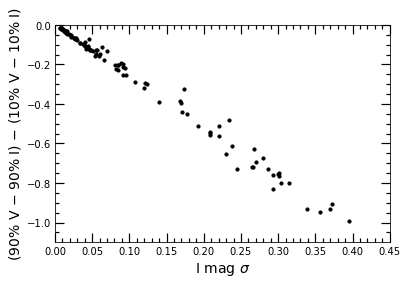

In [58]:
#looking into possible replacements for color-mag slope vs. stdev I

#sort of color at faint end - color at bright end vs. I mag variability
#partially shows, I think, that I mag variation drives color changes (higher amplitude changes)
plt.scatter(summ['stdev I'],summ['90% V-I']-summ['10% V-I'],color='black',s=10)
plt.xlim(0,.45)
plt.ylim(-1.1,0)
plt.xlabel(r'I mag $\sigma$',fontsize=14)
plt.ylabel(r'(90% V $-$ 90% I) $-$ (10% V $-$ 10% I)',fontsize=14)

plt.show()


# detrended phase-folded V and V-I 


In [8]:
def fold_both(src,period=0,det=True):
    if period==0: period = summ[summ['src_n']==src].iloc[0]['best 2-200d period']
    try:iband,vband = o.getIV(src,cross,both=True,stack=True,plot=False)
    except:iband,vband = o.getIV(src,cross2,mlist=mlist2,both=True,stack=True,plot=False)
    if det:
        iband = o.splinedetrend(iband,rettemp=True)
        vband = o.splinedetrend_vband(vband,rettemp=True)
    nsrc = src_dict[src]
    print(f'Source #{nsrc}')
    o.phasestep(iband,period,16,det=det,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='')
    plt.show()
    o.phasestep(vband,period,16,det=det,med=False,double=True,color='black',err=True,retall=False,epoch=0,sterr=True,divide=True,label='',usev=True)
    plt.show()

In [9]:
#similar to above but plot folded I and folded V-I with points shown
def fold_color(src,period=0,det=True,show_points=False):
    if period==0: period = summ[summ['src_n']==src].iloc[0]['best 2-200d period']
    try:iband,vband = o.getIV(src,cross,both=True,stack=True,plot=False)
    except:iband,vband = o.getIV(src,cross2,mlist=mlist2,both=True,stack=True,plot=False)
    if det:
        iband = o.splinedetrend(iband,rettemp=True)
        vband = o.splinedetrend_vband(vband,rettemp=True)
        i_interp = np.interp(vband['MJD-50000'],iband['MJD-50000'],iband['I detrend'])
        vband['V-I detrend'] = vband['V detrend'] - i_interp
    else:
        i_interp = np.interp(vband['MJD-50000'],iband['MJD-50000'],iband['I mag'])
        vband['V-I mag'] = vband['V mag'] - i_interp
        
    nsrc = src_dict[src]
    mid,avg,err = o.meanphase(iband,period,pbins=16,det=det)
    if show_points:
        plt.scatter((iband['MJD-50000']%period)/period,iband['I mag'],color=pink,alpha=0.3,s=5)
        plt.scatter(1+(iband['MJD-50000']%period)/period,iband['I mag'],color=pink,alpha=0.3,s=5)
    plt.step(mid,avg,where='mid',color=pink)
    plt.errorbar(mid,avg,yerr=err,color=pink,marker='',linestyle='none',alpha=0.4)
    maxa,mina = np.nanmax(avg)+err[np.nanargmax(avg)],np.nanmin(avg)-err[np.nanargmin(avg)]
    plt.ylim(maxa+.01,mina-.01)
    plt.xlabel('Phase',fontsize=14)
    plt.ylabel('I mag',fontsize=14)
    nsrc = src_dict[src]
    name = name_dict[src]
    if len(str(name))>3: plt.title(f'{name} (Source #{nsrc})',fontsize=14)
    else: plt.title(f'Source #{nsrc}',fontsize=14)
    ax = plt.gca()
    ax.yaxis.label.set_color(pink)
    ax.spines["left"].set_edgecolor(pink)
    ax.tick_params(axis='y', colors=pink)
    
    color_ax = plt.twinx()    
    mid,avg,err = o.meanphase(vband,period,pbins=16,det=det,band='V-I')
    color_ax.step(mid,avg,where='mid',color='navy',ls='dotted')
    color_ax.errorbar(mid,avg,yerr=err,color='navy',marker='',linestyle='none',alpha=0.2)
    color_ax.set_ylabel('V-I mag',fontsize=14,rotation=270,labelpad=15)
    color_ax.yaxis.label.set_color('navy')
    color_ax.spines["right"].set_edgecolor('navy')
    color_ax.tick_params(axis='y', colors='navy')
    
    plt.show()

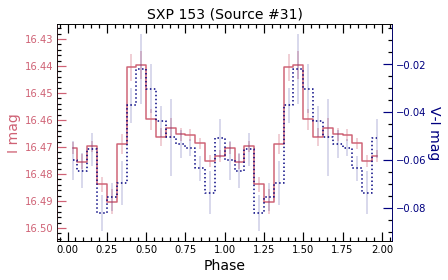

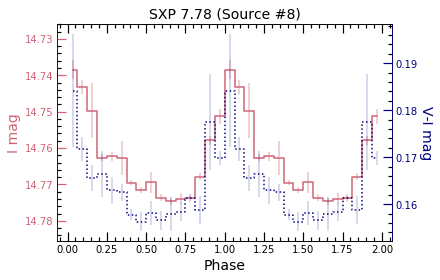

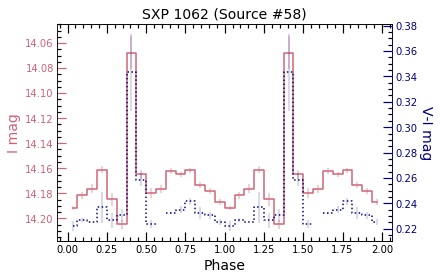

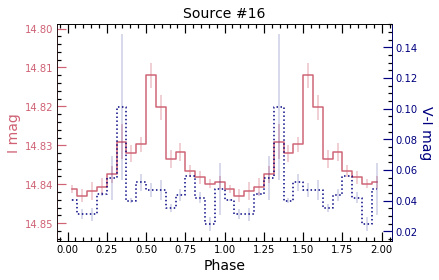

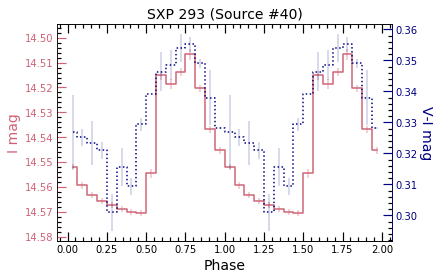

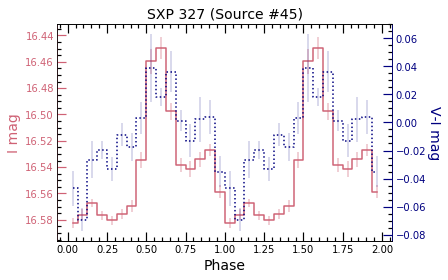

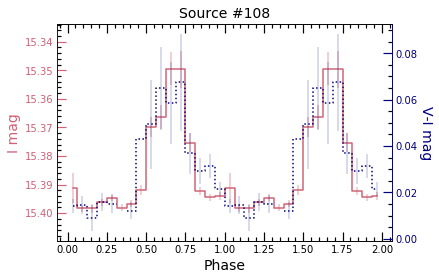

In [10]:
#generally just conclude redder when brighter specifically within orbital phase as well
fold_color(35,period=101.7)
fold_color(9)
fold_color(63,det=False,period=656)
fold_color(17)
fold_color(45)
fold_color(50)
fold_color(142)

Source #31


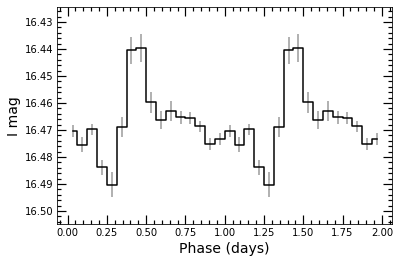

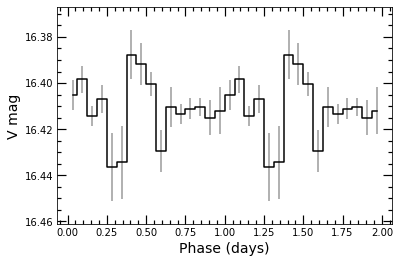

Source #8


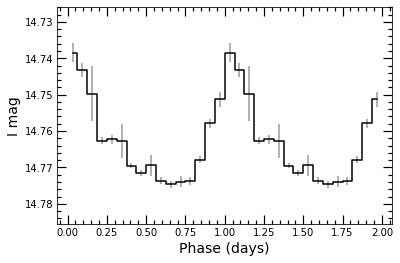

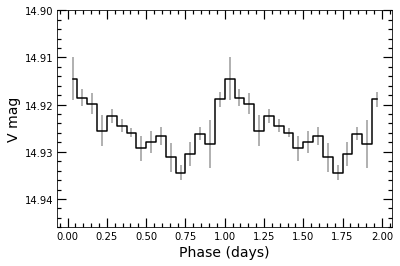

Source #58


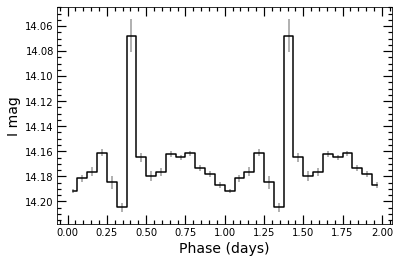

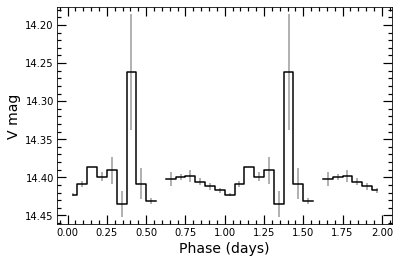

Source #16


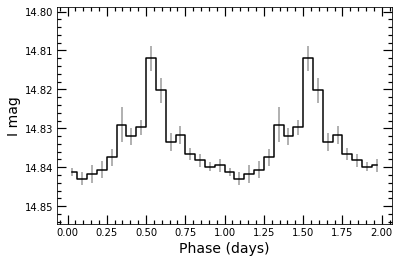

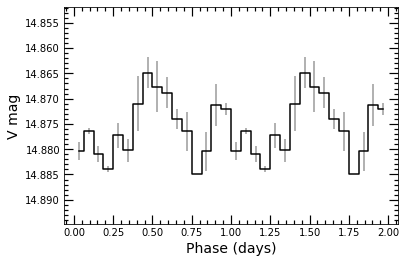

Source #40


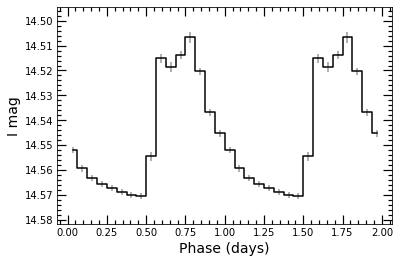

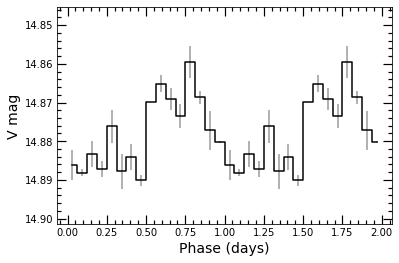

Source #45


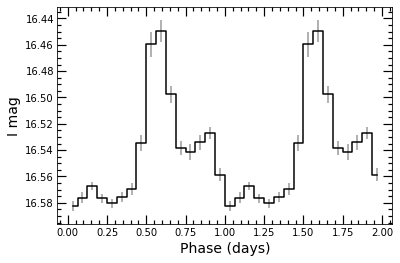

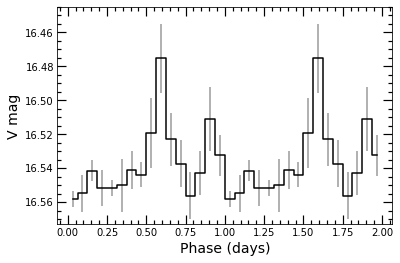

Source #108


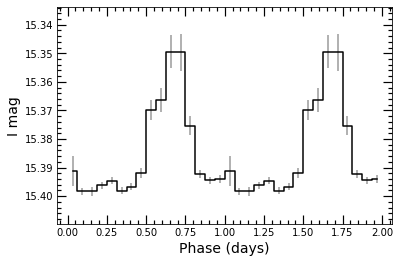

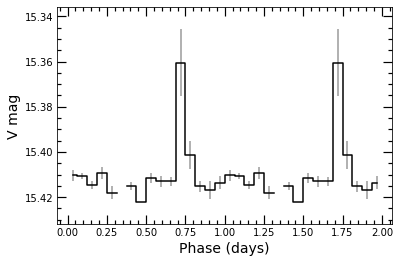

In [11]:
#a few that actually show up in V
fold_both(35,period=101.7)
fold_both(9)
fold_both(63,det=False,period=656)
fold_both(17)
fold_both(45)
fold_both(50)
fold_both(142)
#could be still good to check color on orbital timescales
# fold_both(22)# fold_both(23)# fold_both(28)# fold_both(30)# fold_both(60,period=392.33)# fold_both(115)

# color-mag loops
- will want to do another visual analysis to see which have loops
- note: recalculated bright res monotonic frac so be sure to use this newer version (see older in FINAL_colormag/FinalFigures notebooks)
    - older version only required two points to have a monotonic trend; seems to work better/make more sense with three

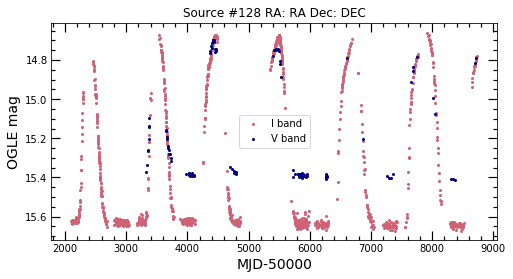

I and V-I correlation: -0.945568932143824
V and V-I correlation: -0.8840279171742701


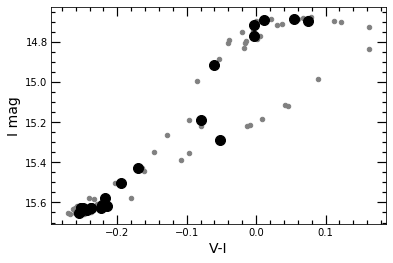

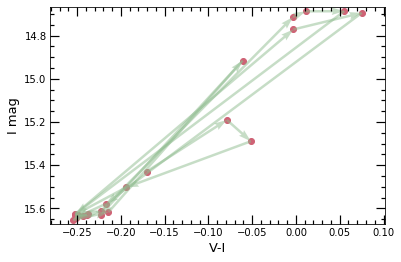

In [59]:
iband,vband = o.getIV(128,cross2,mlist=mlist2,both=True,stack=True,plot=True)
plt.show()
interp = o.colormag(iband,vband,retint=True,plot=False,both=False,figsize=(6,4))
vi = vband['V mag'] - interp

med_i = []
med_vi = []
med_v = []
points_to_average = 5
start_index=0
#can also simplify with array_split in the future: # np.array_split(interp,10) #but then not sure how to return median of each esp. b/c can't be 2D since unequal number of elements
for i in range(int(len(interp)/points_to_average)):
    med_i.append(np.nanmedian(interp[start_index:start_index+points_to_average]))
    med_vi.append(np.nanmedian(vi[start_index:start_index+points_to_average]))
    med_v.append(np.nanmedian(vband['V mag'][start_index:start_index+points_to_average]))
    start_index+=points_to_average
plt.scatter(med_vi,med_i,color='black',s=100,zorder=3)
# plt.plot(med_vi,med_i,color='black')
plt.scatter(vi,interp,color='grey',s=20)
# plt.ylim(np.max(med_i)+0.01,np.min(med_i)-0.01)
plt.ylim(np.max(interp)+0.05,np.min(interp)-0.05)
plt.xlabel('V-I',fontsize=14)
plt.ylabel('I mag',fontsize=14)
plt.show()
o.carrow(np.array(med_v),np.array(med_i),np.array(med_vi)) #arrow version


simplified original function calculated loop metric components by taking out optionality that's not used
- can always grab more complex version in FINAL_colormag.ipynb
    - if adding plotting back in, add in as separate function
- also changing variable names

In [91]:
def res_brightness(srcn,frac=0.5):
    if src_dict[srcn] in calibration_used:calib=True
    else:calib=False
    if src_dict[srcn] in exclude_OII_from_color:
        iband,vband = exclude_OII(srcn,plot=False,calib=calib)
    else:
        try: iband, vband = o.getIV(srcn,cross,stack=True,plot=False,calib=calib)
        except: iband, vband = o.getIV(srcn,cross2,stack=True,plot=False,mlist=mlist2,calib=calib)
    interp = np.interp(vband['MJD-50000'],iband['MJD-50000'],iband['I mag'])

    #frame with Iint, Vmag, and V-I
    color = pd.DataFrame(columns=['day','I','V','V-I','residual'])
    color['I'],color['V'],color['V-I'] = interp,vband['V mag'],vband['V mag']-interp
    color['day'] = vband['MJD-50000']
    
    maxi,mini = np.max(interp),np.min(interp)
    #cutoff measured from max (faint), so large frac yields smaller bright frame
    bright = color[color['I']<(maxi-(maxi-mini)*frac)]
    faint = color[color['I']>(maxi-(maxi-mini)*frac)]

    #fit line to I vs. V-I for bright and faint values
    bright_fit = np.polyfit(bright['V-I'],bright['I'],1)
    faint_fit = np.polyfit(faint['V-I'],faint['I'],1)
    
    #expected values using linear fit
    expected_bright = bright['V-I']*bright_fit[0] + bright_fit[1]
    expected_faint = faint['V-I']*faint_fit[0] + faint_fit[1]
    
    #find residuals from best fit 
    bright['residual'] = bright['I'] - expected_bright
    faint['residual'] = faint['I'] - expected_faint

    #mean absolute value of residuals (estimate of scatter around fit)
    bright_residual_mean = np.mean(np.abs(bright['residual']))
    faint_residual_mean = np.mean(np.abs(faint['residual']))
            
    #fit line to bright residuals vs. I mag
    bright_residual_fit = np.polyfit(bright['I'],bright['residual'],1)
    faint_residual_fit = np.polyfit(faint['I'],faint['residual'],1)
        
    #overwrites tables
    mono_frac,nswitch = o.mono_count(bright,faint,minimum=3,col='residual',divide=True)
    
    return [bright_residual_mean,faint_residual_mean,bright_residual_fit[0]-faint_residual_fit[0],mono_frac,nswitch,bright_fit[0]-faint_fit[0]] 

In [92]:
#reset the summ columns
summ['bright res monotonic frac'] = np.nan
summ['mean abs bright residual'] = np.nan
summ['mean abs faint residual'] = np.nan
summ['residual slope diff'] = np.nan
summ['bright - faint slope'] = np.nan

#calculate for all but remember to exclude exclude_all_from_color when plotting
#res_brightness excludes OII when necessary, checks if calibration should be used
fsums,bsums,slopes,fracs,nswitch,sdiff = [],[],[],[],[],[]
for s in summ['src_n']:
    try: 
        b,f,bslope,mfrac,ns,sd = res_brightness(s)
        fsums.append(f);bsums.append(b);slopes.append(bslope);fracs.append(mfrac); sdiff.append(sd);nswitch.append(ns)
    except:
        print(f'source {s} not found')
        fsums.append(np.nan);bsums.append(np.nan);slopes.append(np.nan);fracs.append(np.nan); sdiff.append(np.nan); nswitch.append(np.nan)

# summ['number switch'] = nswitch 
summ['mean abs bright residual'] = bsums
summ['mean abs faint residual'] = fsums
summ['bright res monotonic frac'] = fracs 
summ['number switch'] = nswitch
summ['residual slope diff'] = slopes
summ['bright - faint slope'] = sdiff

source 1 not found
empty file for OIII I
empty file for OII I
source 78 not found
empty file for OIII I


In [93]:
nmfrac = summ['bright res monotonic frac']/np.nanmax(summ['bright res monotonic frac'])
bres = summ['mean abs bright residual']/np.nanmax(summ['mean abs bright residual']) #other options to try out
fres = summ['mean abs faint residual']/np.nanmax(summ['mean abs faint residual'])
nresdiff = (summ['mean abs bright residual']-summ['mean abs faint residual'])/np.nanmax(summ['mean abs bright residual']-summ['mean abs faint residual'])
nslope = summ['residual slope diff']/np.nanmax(summ['residual slope diff'])

summ['loop metric'] = nmfrac + nresdiff + nslope #but potentially better to not use all these in metric

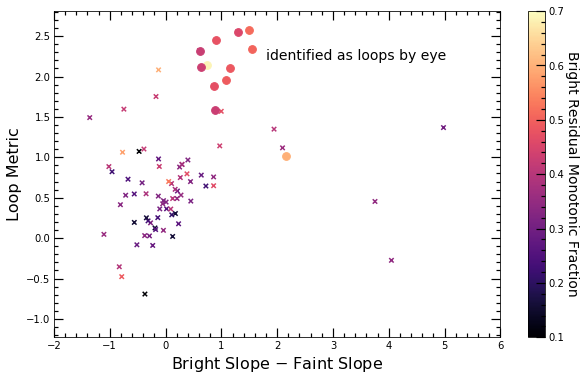

In [63]:
use = summ[summ['exclude from color-mag']=='no']
plt.figure(figsize=(10,6))
plt.scatter(use['bright - faint slope'],use['loop metric'],c=use['bright res monotonic frac'],vmin=0.1,vmax=0.7,s=20,cmap='magma',marker='x')
cbar = plt.colorbar()
cbar.set_label('Bright Residual Monotonic Fraction',fontsize=14,rotation=270,labelpad=15)

plt.xlim(-2,6)
# plt.ylim(-.5,3)
plt.text(1.8,2.2,'identified as loops by eye',fontsize=14)

plt.xlabel(r'Bright Slope $-$ Faint Slope',fontsize=16)
plt.ylabel(r'Loop Metric',fontsize=16)
loops = [3,15,16,13,27,46,125,80,87,132,128,104]
for l in loops:
    row = use[use['src_n']==l]
    nsrcn = src_dict[l]
    plt.scatter(row['bright - faint slope'],row['loop metric'],s=60,c=row['bright res monotonic frac'],cmap='magma',vmin=0.1,vmax=0.7,marker='o')

plt.savefig('ColorFigsMar23/loop_metric.pdf',bbox_inches='tight') 

# (refined) examples of type 1 and 2 loops with arrows

Text(0.5, 0.98, 'Source #100')

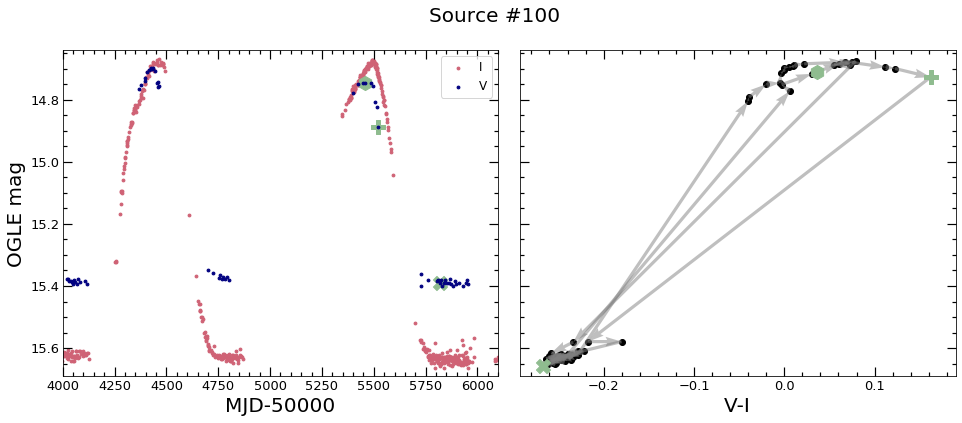

In [22]:
#now with subplots showing corresponding cm
fig,(ax,ax1) = plt.subplots(1,2,figsize=(16,6),sharey=True)
fig.subplots_adjust(wspace=0.05)
iband,vband = o.getIV(128,cross2,mlist=mlist2,stack=True)
interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=8,label='I')
#not average points just to guide the eye
ax.scatter(vband['MJD-50000'][60:61],vband['V mag'][60:61],s=200,color='darkseagreen',marker='h')
ax.scatter(vband['MJD-50000'][71:72],vband['V mag'][71:72],s=200,color='darkseagreen',marker='X')
ax.scatter(vband['MJD-50000'][65:66],vband['V mag'][65:66],s=200,color='darkseagreen',marker='P')

maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
ax.set_ylim(maxi+.02,mini-.02)

ax.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=8,label='V')
ax.set_xlim(4000,6100)
ax.set_xlabel('MJD-50000',fontsize=20)
ax.set_ylabel('OGLE mag',fontsize=20)
ax.legend(fontsize=12)
ax.tick_params(labelsize=13)
ax1.tick_params(labelsize=13)
#plot color mag from this part
ib = iband[iband['MJD-50000']>4000];ib = ib[ib['MJD-50000']<6100]
vb = vband[vband['MJD-50000']>4000];vb = vb[vb['MJD-50000']<6100]
#new int
inte = o.colormag(ib,vb,retint=True,printcorr=False,plot=False)
vi = vband['V mag']-interp
ax1.scatter(vi[60:61],interp[60:61],s=200,color='darkseagreen',marker='h',zorder=10)
ax1.scatter(vi[71:72],interp[71:72],s=200,color='darkseagreen',marker='X',zorder=10)
ax1.scatter(vi[65:66],interp[65:66],s=200,color='darkseagreen',marker='P',zorder=10)
yvect = interp[1:]-interp[:-1]
xvect = vi[1:]-vi[:-1]
#add arrows in time
ax1.set_xlabel('V-I',fontsize=20)
ib = iband[iband['MJD-50000']>4000];ib = ib[ib['MJD-50000']<6100]
vb = vband[vband['MJD-50000']>4000];vb = vb[vb['MJD-50000']<6100]
inte = o.colormag(ib,vb,retint=True,printcorr=False,plot=False)
vi = vb['V mag']-inte
im = ax1.scatter(vi,inte,color='black')
yvect = inte[1:]-inte[:-1]
xvect = vi[1:]-vi[:-1]
ax1.quiver(vi[:-1],inte[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.5)
fig.suptitle('Source #100',fontsize=20) #no spin period so not sure if there's a name
# plt.savefig('loopivsubplots.png',dpi=200,bbox_inches='tight') #overwrote old version and added to Overleaf

Text(0.5, 0.98, 'Source #72')

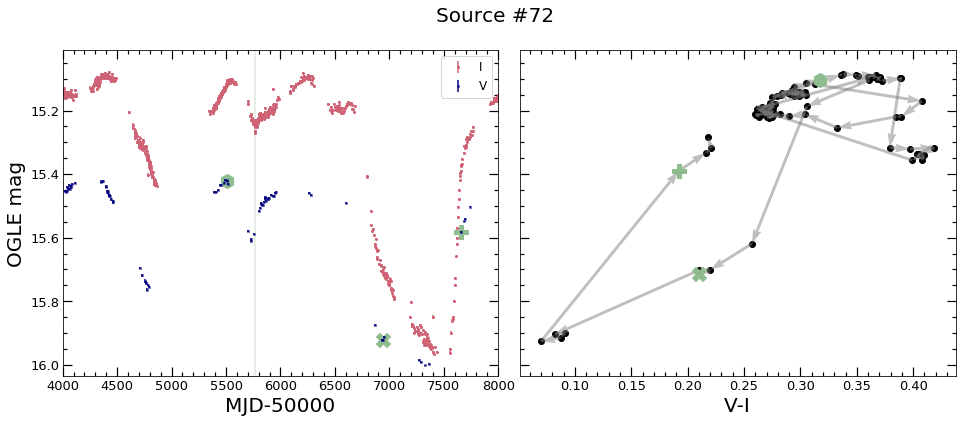

In [23]:
#do similar zoom-in with one of these sources
fig,(ax,ax1) = plt.subplots(1,2,figsize=(16,6),sharey=True)
fig.subplots_adjust(wspace=0.05)
iband,vband = o.getIV(80,cross2,mlist=mlist2,stack=True)
interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
# ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=8,label='I')
maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
ax.set_ylim(maxi+.07,mini-.02)
add = 15
sub = 4
ax.errorbar(iband['MJD-50000'],iband['I mag'],yerr=iband['I mag err'],color=pink,markersize=2,ls='None',marker='o',label='I')
ax.scatter(vband['MJD-50000'][105:106],vband['V mag'][105:106],s=200,color='darkseagreen',marker='h')
ax.scatter(vband['MJD-50000'][120+add:121+add],vband['V mag'][120+add:121+add],s=200,color='darkseagreen',marker='X')
ax.scatter(vband['MJD-50000'][130+add-sub:131+add-sub],vband['V mag'][130+add-sub:131+add-sub],s=200,color='darkseagreen',marker='P')

ax.errorbar(vband['MJD-50000'],vband['V mag'],yerr=vband['V mag err'],color='navy',label='V',markersize=2,ls='None',marker='x')
ax.set_xlim(4000,8000)
ax.set_xlabel('MJD-50000',fontsize=20)
ax.set_ylabel('OGLE mag',fontsize=20)
ax.legend(fontsize=12)
ax.tick_params(labelsize=13)
ax1.tick_params(labelsize=13)
#new int
vi = vband['V mag']-interp
yvect = interp[1:]-interp[:-1]
xvect = vi[1:]-vi[:-1]

# ax1.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.5)
ax1.scatter(vi[105:106],interp[105:106],s=200,color='darkseagreen',marker='h',zorder=10)
ax1.scatter(vi[120+add:121+add],interp[120+add:121+add],s=200,color='darkseagreen',marker='X',zorder=10)
ax1.scatter(vi[130+add-sub:131+add-sub],interp[130+add-sub:131+add-sub],s=200,color='darkseagreen',marker='P',zorder=10)
#add arrows in time
ax1.set_xlabel('V-I',fontsize=20)
ax.axvline(5770,color='darkseagreen',alpha=0.3)

#option to just show color-mag from part of LC shown
ib = iband[iband['MJD-50000']>4000];ib = ib[ib['MJD-50000']<8000]
vb = vband[vband['MJD-50000']>4000];vb = vb[vb['MJD-50000']<8000]
inte = o.colormag(ib,vb,retint=True,printcorr=False,plot=False)
vi = vb['V mag']-inte
im = ax1.scatter(vi,inte,color='black')
yvect = inte[1:]-inte[:-1]
xvect = vi[1:]-vi[:-1]
ax1.quiver(vi[:-1],inte[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.5)
fig.suptitle('Source #72',fontsize=20) #no spin period so not sure if there's a name
# plt.savefig('type2loopsubplots.png',dpi=200,bbox_inches='tight') #overwrote old version and added to Overleaf

# investigate V band leading I (both 1 and 2)
- at what time shift do they have the best correlation?
- or when do minima and maxima occur (i.e., peak-finding algorithm)

# any looping sources go counterclockwise or both directions?

# separation of types of loops
- options for this in FINAL_colormag

In [94]:
summ.to_csv('Feb23_summtab.csv',index=False)

# example color-mag gallery, gallery by type

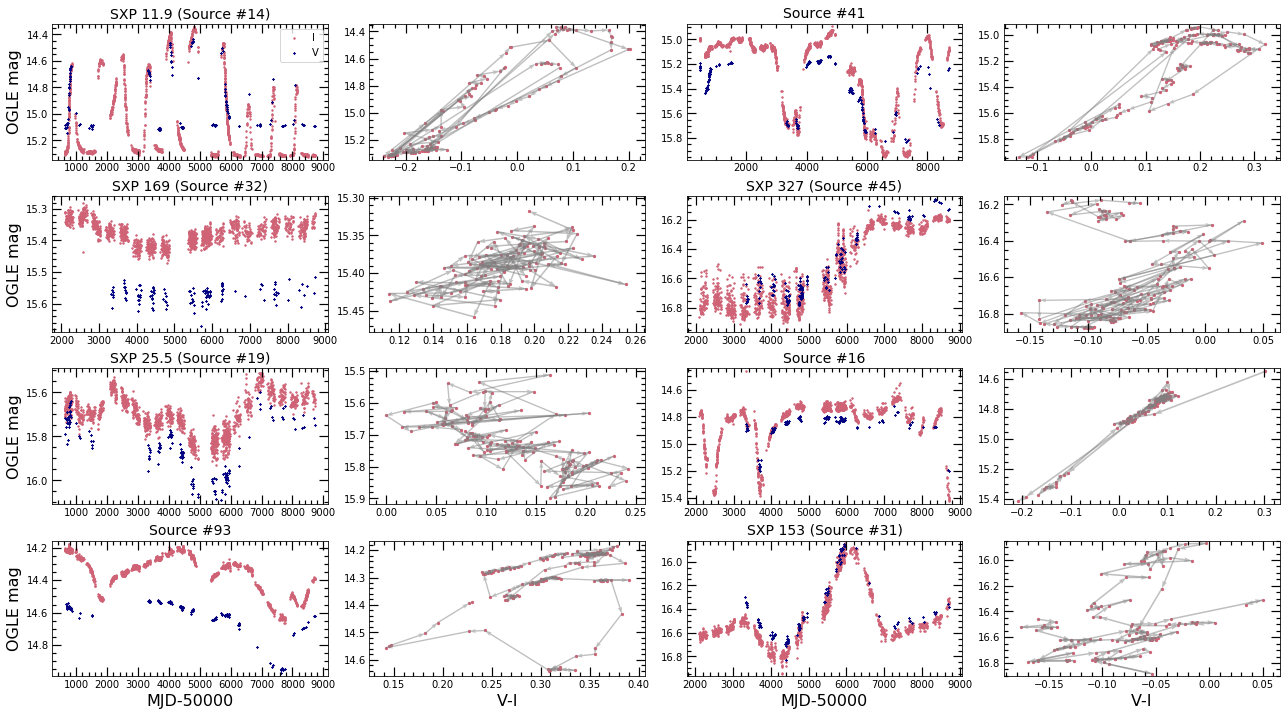

In [32]:
reps = [15,46,36,50,21,17,116,35] #old source numbers

fig = plt.figure(figsize=(22,12))
i = 1
for r in reps:
    ax = fig.add_subplot(4,4,i)
    nsrcn = src_dict[r]
    name = name_dict[r]
    if nsrcn in exclude_all_from_color: print(f'exclude {r}')
    elif nsrcn in exclude_OII_from_color: print(f'(rewrite to) just exclude OII from {r}')
        
    if nsrcn in calibration_used:calib=True
    else:calib=False
    try:iband,vband = o.getIV(r,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=calib)
    except:iband,vband = o.getIV(r,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=calib)
    interp = np.interp(vband['MJD-50000'],iband['MJD-50000'],iband['I mag'])
    ax.scatter(iband['MJD-50000'],iband['I mag'],s=2,color=pink,label='I')
    ax.scatter(vband['MJD-50000'],vband['V mag'],s=2,color='navy',marker='x',label='V')
    if i==1: ax.legend()
    mini,maxi = np.min([np.min(iband['I mag']),np.min(vband['V mag'])]),np.max([np.max(iband['I mag']),np.max(vband['V mag'])])
    ax.set_ylim(maxi+.02,mini-.02)
    if len(str(name))>3: ax.set_title(f'{name} (Source #{nsrcn})',fontsize=14) 
    else: ax.set_title(f'Source #{nsrcn}',fontsize=14) 
    if (i-1)%4==0:ax.set_ylabel('OGLE mag',fontsize=16)
    if i==13 or i==15: ax.set_xlabel('MJD-50000',fontsize=16)
    i += 1
    ax = fig.add_subplot(4,4,i)
    vi = vband['V mag']-interp
    ax.scatter(vi,interp,s=5,color=pink)
    ax.set_ylim(np.max(interp)+.02,np.min(interp)-.02)
    yvect = interp[1:]-interp[:-1]
    xvect = vi[1:]-vi[:-1]
    ax.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.5)
    if i==14 or i==16: ax.set_xlabel('V-I',fontsize=16)
    i += 1
plt.subplots_adjust(wspace=.15,hspace=.27)
plt.savefig('ColorFigsMar23/colormag_gallery.pdf',bbox_inches='tight')

In [74]:
def type_color(type_list,figsize=0):
    '''
    Plot light curves and color-mag plots for all sources in a superorbital type (or other list)
    
    type_list (list): list of (old) source numbers to include in plot
    '''
    
    if figsize==0:
        #up to three per row (six total panels per row)
        nrows = int(math.ceil(len(type_list)/3))
        ncols = 6
        #if len(type_list)%4==0: nrows,ncols = int(len(type_list)/4),8
        if len(type_list)==2: 
            nrows=1;ncols=4 #for type 4 sources
        figsize=(5*ncols,4*nrows)    
    fig = plt.figure(figsize=figsize)
    i = 1
    for t in type_list:
        nsrcn = src_dict[t]
        name = name_dict[t]
        if nsrcn in calibration_used: calib=True
        else: calib=False
        try:iband,vband = o.getIV(t,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=calib)
        except:iband,vband = o.getIV(t,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=calib)
        #color-mag
        interp = np.interp(vband['MJD-50000'],iband['MJD-50000'],iband['I mag'])
        if nsrcn in exclude_OII_from_color:
            shortened_iband,shortened_vband = exclude_OII(t,calib=calib)
            interp = np.interp(shortened_vband['MJD-50000'],shortened_iband['MJD-50000'],shortened_iband['I mag'])
            framecolor = '#2F9C95'
            pointcolor = pink
        elif nsrcn in exclude_all_from_color:
            framecolor = '#DB2B39'
            pointcolor = 'grey'
        else: 
            framecolor = 'black'
            pointcolor = pink
        ax = fig.add_subplot(nrows,ncols,i)
        #first do I and V mag
        ax.errorbar(iband['MJD-50000'],iband['I mag'],yerr=iband['I mag err'],color=pink,markersize=2,elinewidth=1,label='I',ls='none',marker='o')
        ax.errorbar(vband['MJD-50000'],vband['V mag'],yerr=vband['V mag err'],color='navy',markersize=2,elinewidth=1,label='V',ls='none',marker='o')    
        maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
        if np.max(vband['V mag'])>maxi: maxi = np.max(vband['V mag'])
        if np.min(vband['V mag'])<mini: mini = np.min(vband['V mag'])
        ax.set_ylim(maxi+.1,mini-.1)
        #set labels
        if i==1:ax.legend(fontsize=14)
        if i > ncols*nrows - ncols: ax.set_xlabel('MJD-50000',fontsize=16)
        if i%ncols==1: ax.set_ylabel('OGLE mag',fontsize=16)
        if len(str(name))>3: ax.set_title(f'{name} (Source #{nsrcn})',fontsize=16)
        else: ax.set_title(f'Source #{nsrcn}',fontsize=16)
            
        #now color mag
        i+=1
        ax = fig.add_subplot(nrows,ncols,i)
        if nsrcn in exclude_OII_from_color: vband = shortened_vband
        vi = vband['V mag']-interp
        ax.scatter(vi,interp,color=pointcolor,s=5)
        yvect = interp[1:]-interp[:-1]
        xvect = vi[1:]-vi[:-1]
        ax.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.4,headwidth=8)
        plt.setp(ax.spines.values(), color=framecolor)
        maxi,mini = np.max(interp),np.min(interp)
        ax.set_ylim(maxi+.02,mini-.02)
        if i > ncols*nrows - ncols:ax.set_xlabel('V-I',fontsize=16)
        i+=1


In [38]:
type1 = o.gettype(summ,num='1')
type2 = o.gettype(summ,num='2')
type3 = o.gettype(summ,num='3')
type4 = o.gettype(summ,num='4')
type5 = o.gettype(summ,num='5')
type6 = o.gettype(summ,num='6')
#transition sources
typet = []
for i in range(len(summ)):
    row = summ.iloc[i]
    src = row['src_n']
    if '+' in str(row['type']):
        typet.append(int(src))

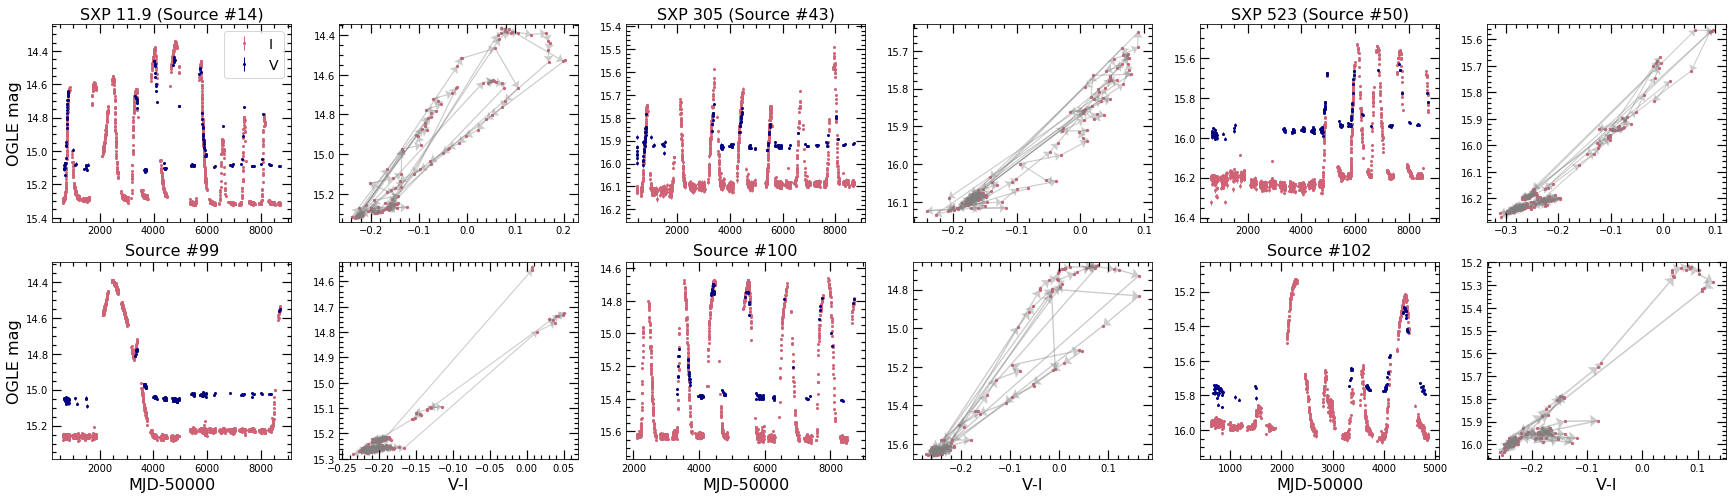

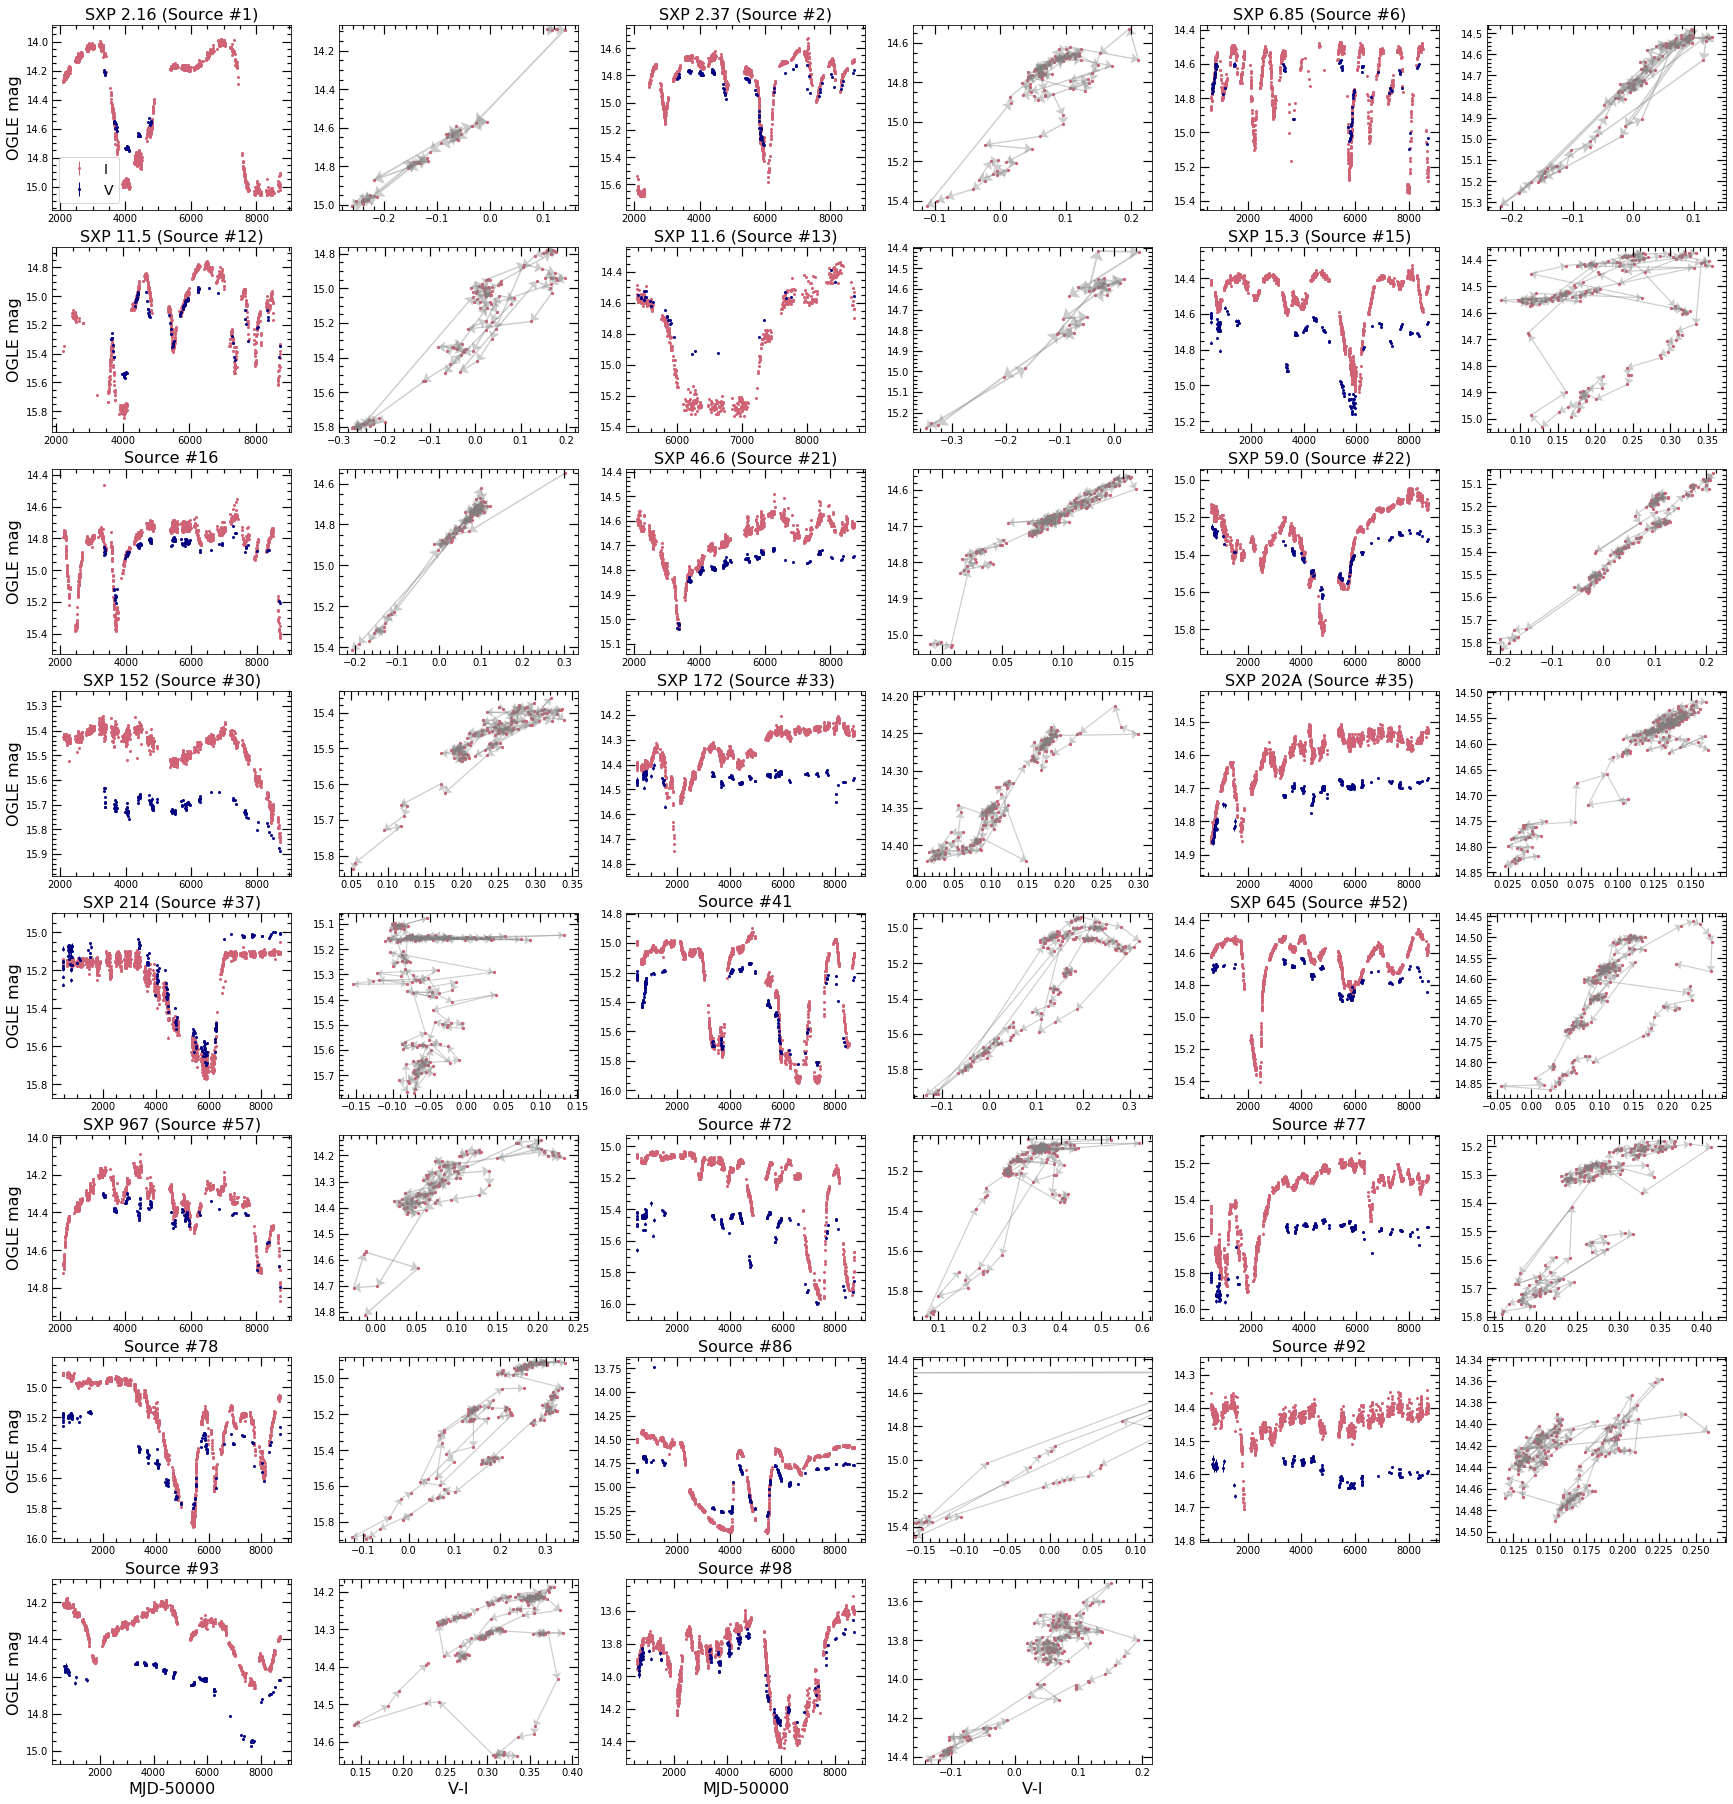

In [43]:
type_color(type1)
plt.savefig('ColorFigsMar23/type1_gallery.png',dpi=150,bbox_inches='tight')
plt.show()
type_color(type2)
plt.savefig('ColorFigsMar23/type2_gallery.png',dpi=150,bbox_inches='tight')
plt.show()

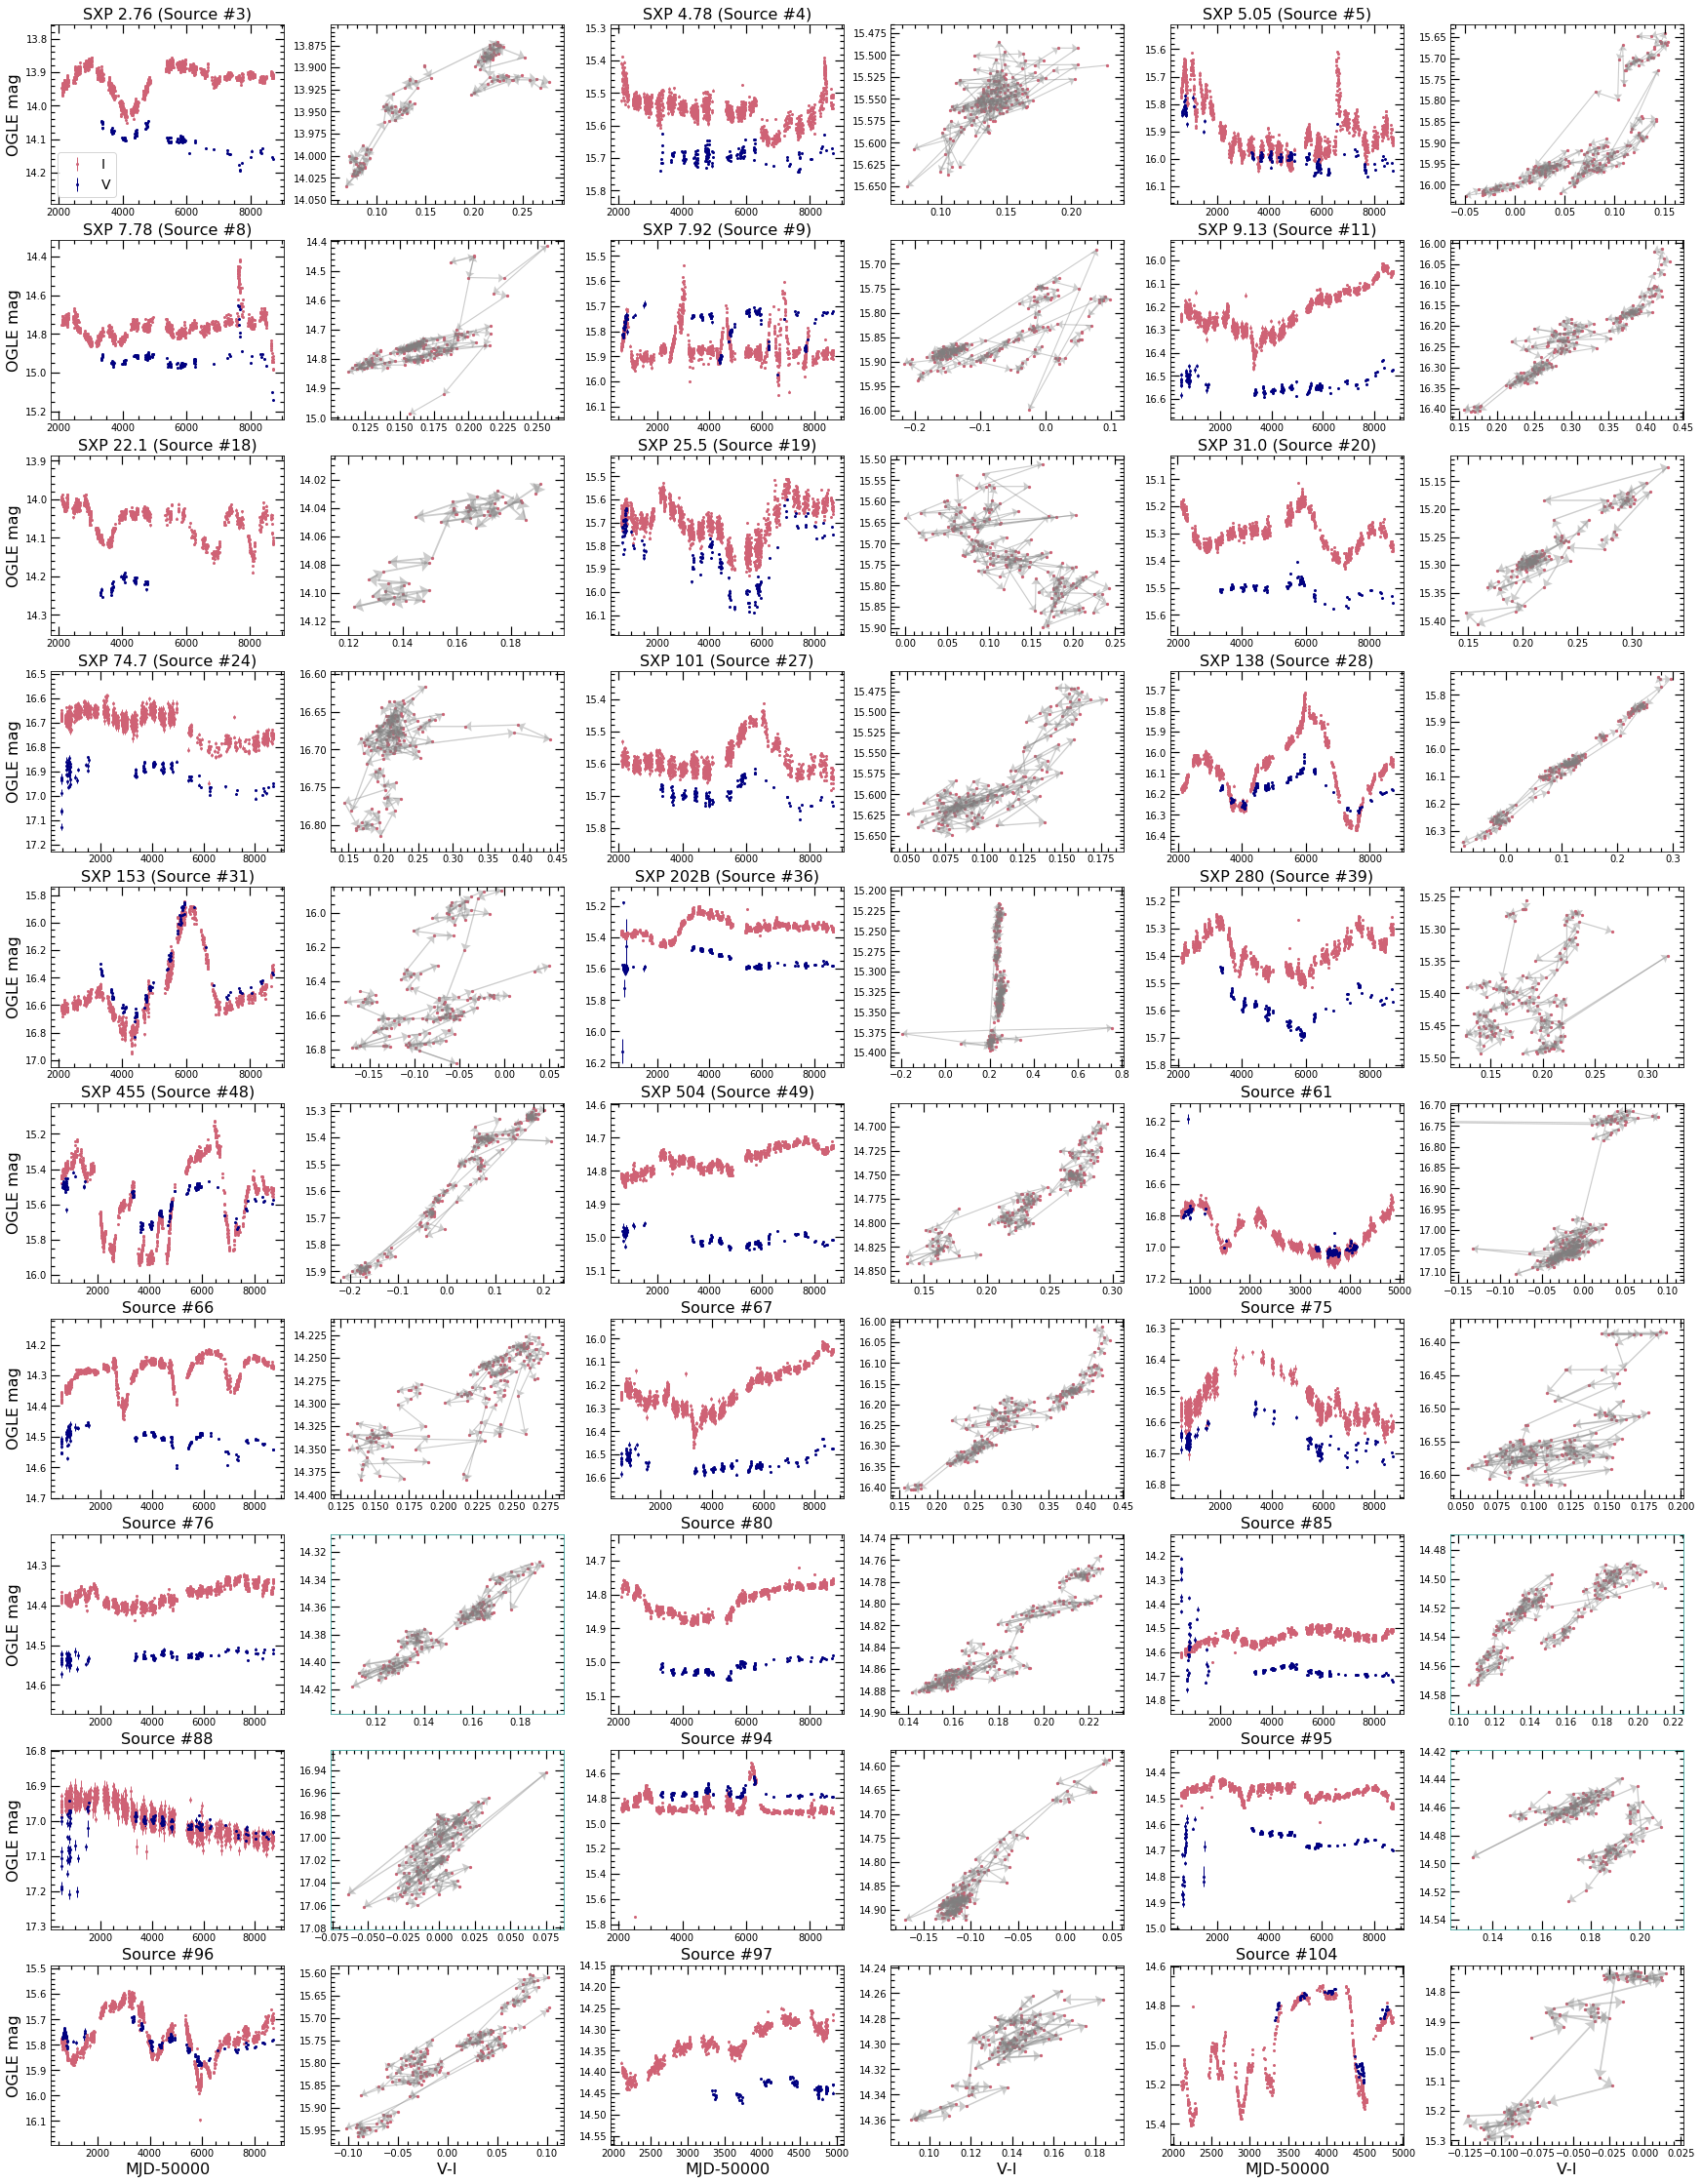

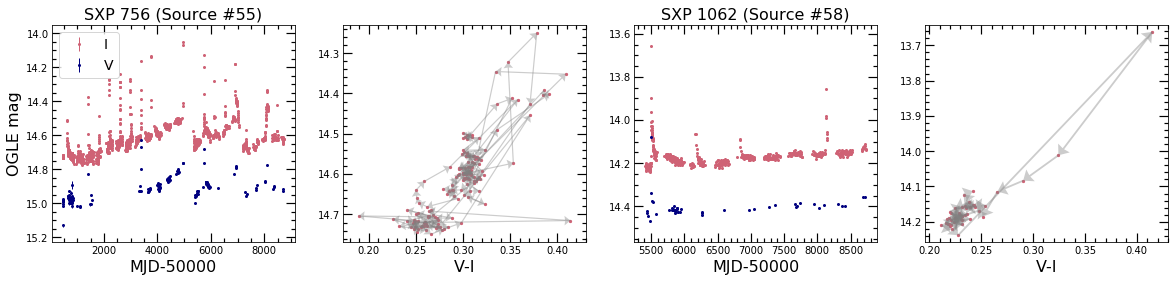

In [44]:
type_color(type3)
plt.savefig('ColorFigsMar23/type3_gallery.png',dpi=150,bbox_inches='tight')
plt.show()
type_color(type4)
plt.savefig('ColorFigsMar23/type4_gallery.png',dpi=150,bbox_inches='tight')
plt.show()

I and V-I correlation: -0.16860135254047037
V and V-I correlation: 0.951775471776383


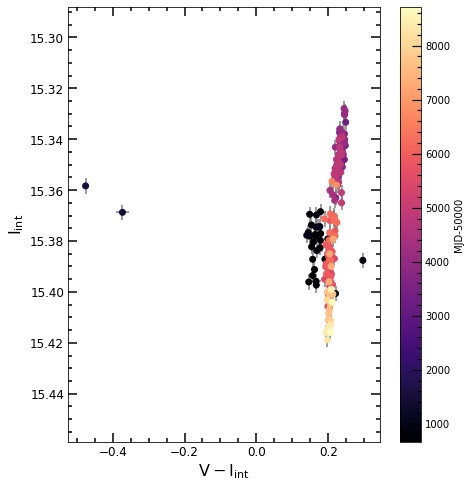

In [73]:
try:iband,vband = o.getIV(65,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=calib)
except:iband,vband = o.getIV(65,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=calib)
o.colormag(iband,vband,both=False)

empty file for OIII I
empty file for OIII I


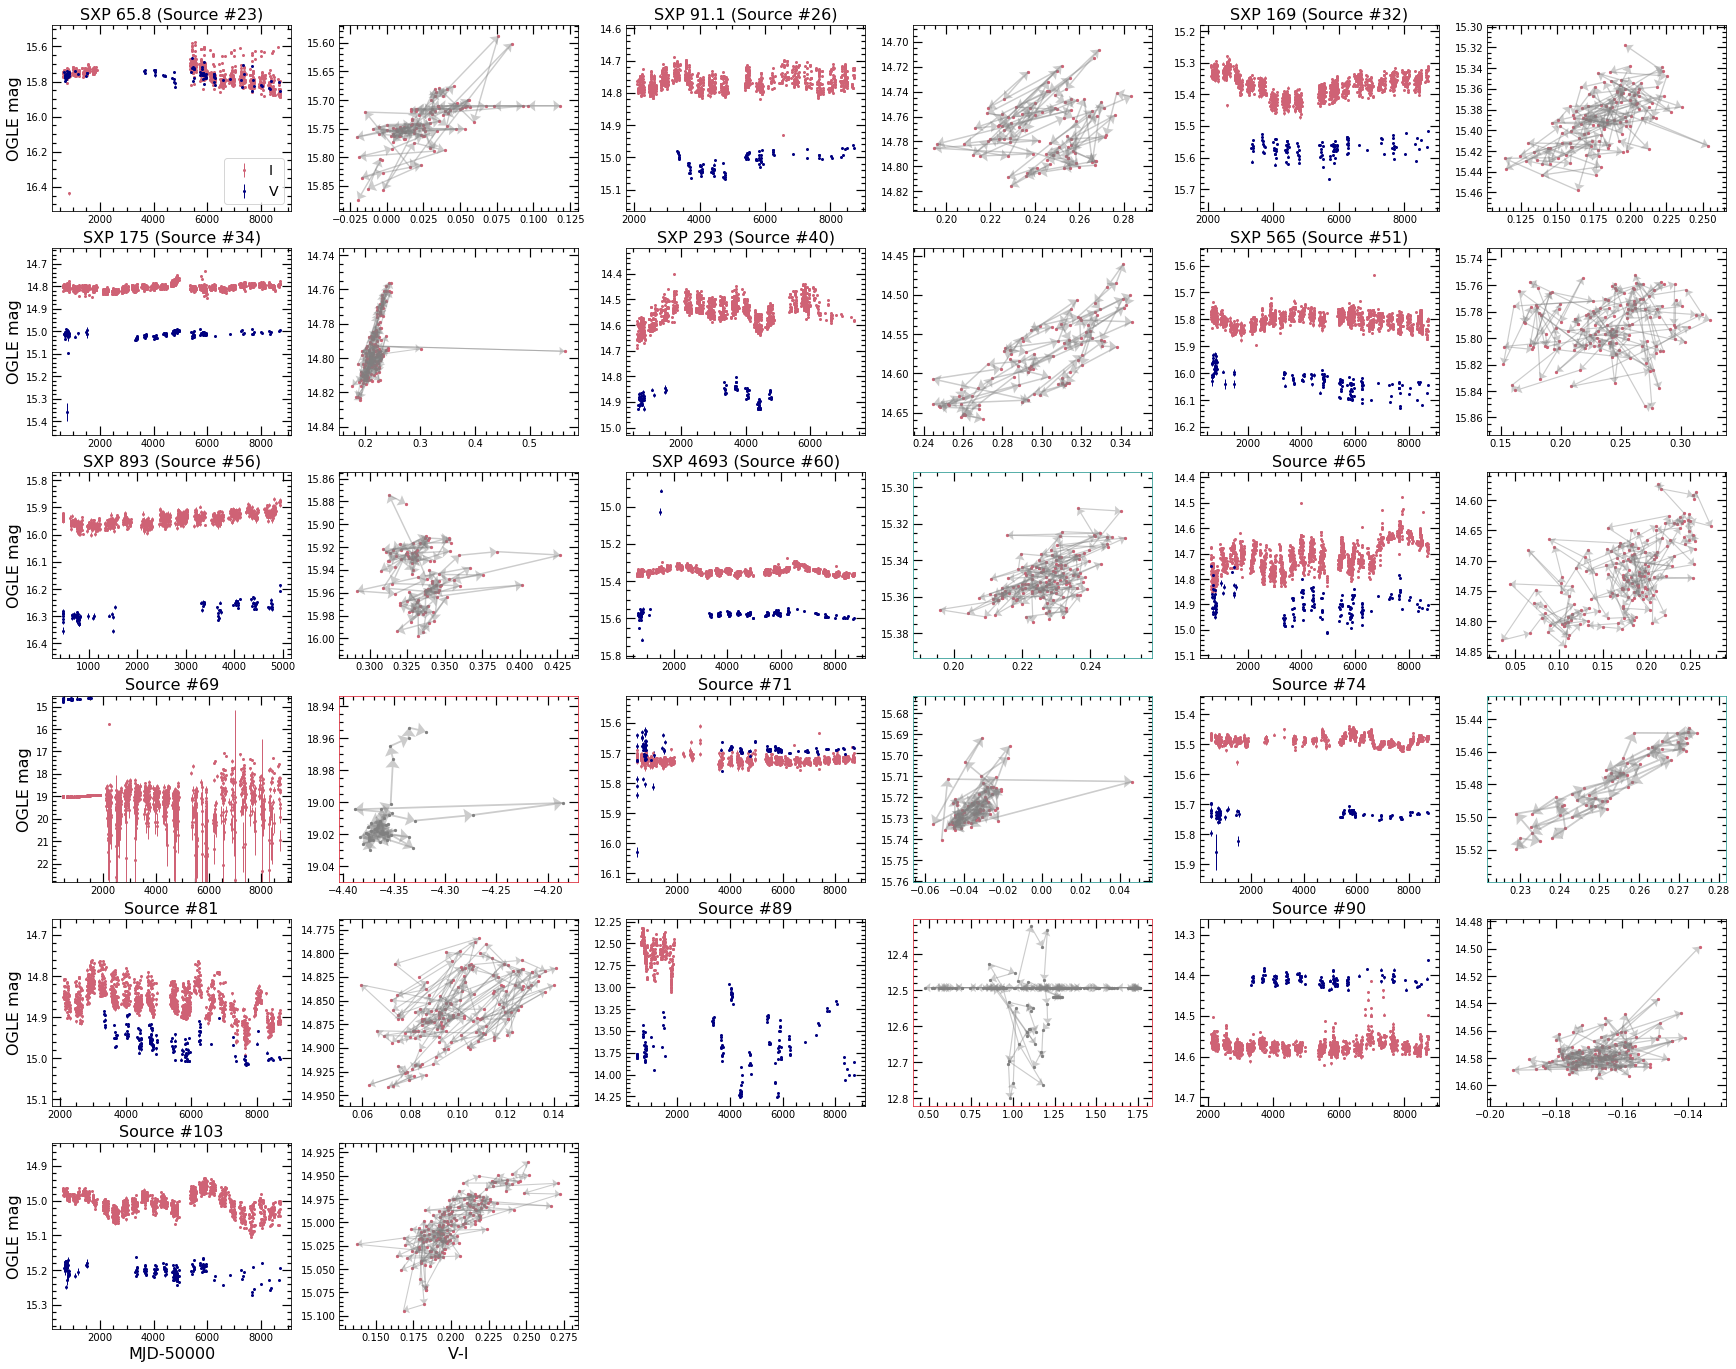

empty file for OII I


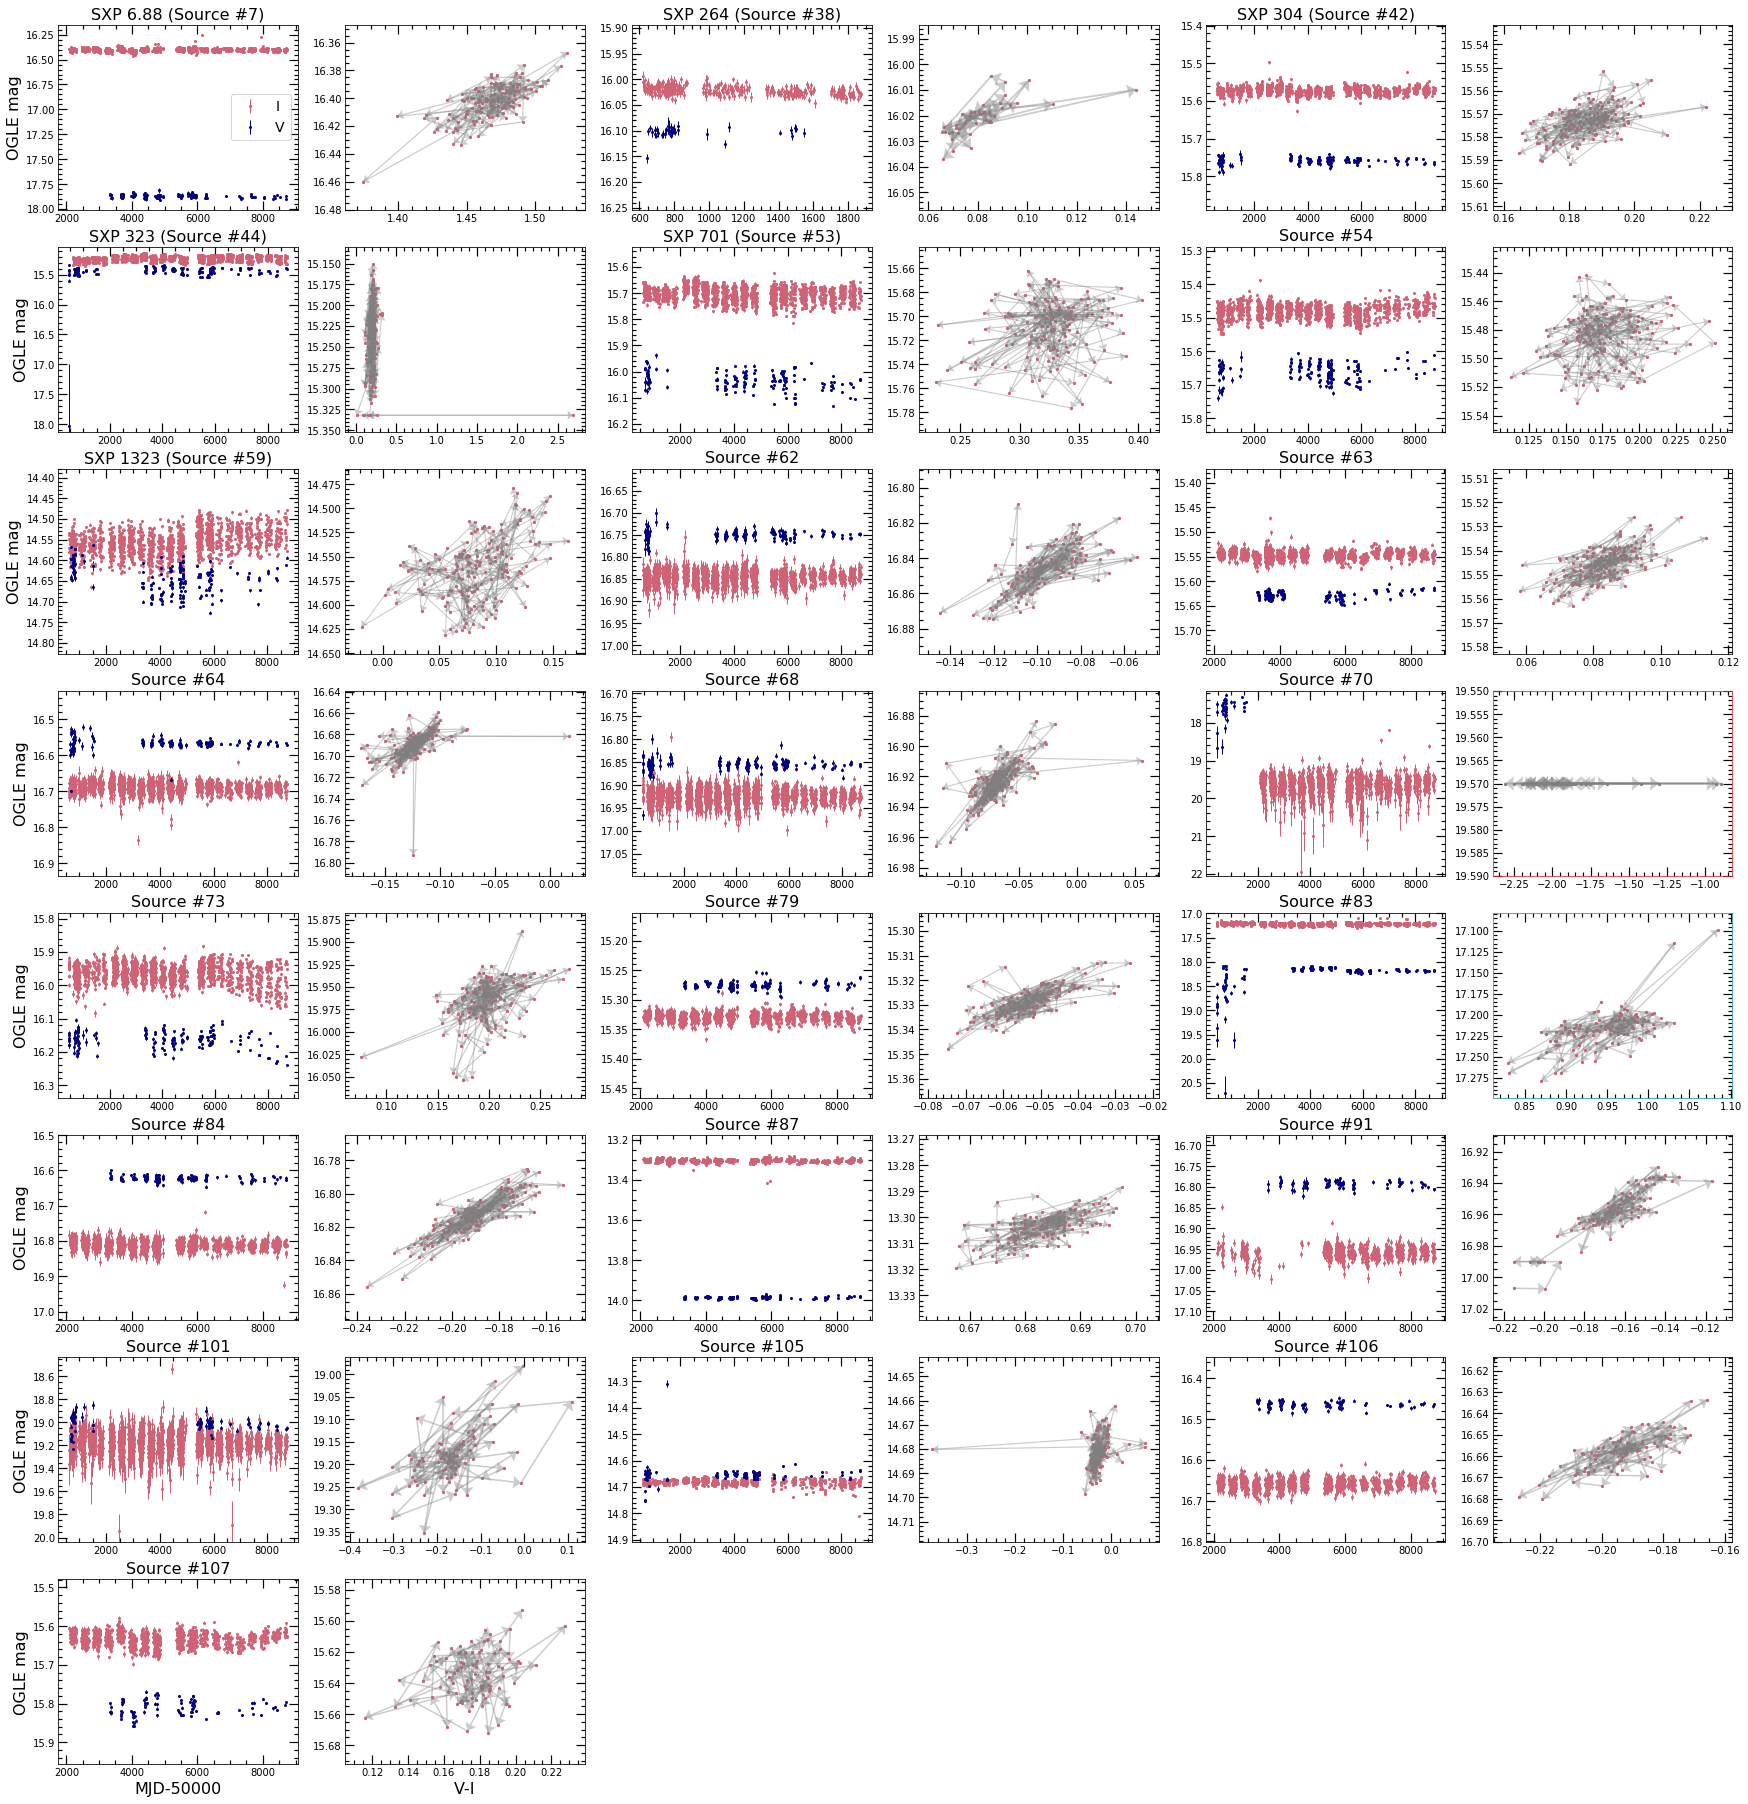

In [75]:
type_color(type5)
plt.savefig('ColorFigsMar23/type5_gallery.png',dpi=150,bbox_inches='tight')
plt.show()
type_color(type6)
plt.savefig('ColorFigsMar23/type6_gallery.png',dpi=150,bbox_inches='tight')
plt.show()

# color- and type-related correlations
- I V-I slope vs. standard deviation ratio and vs. standard deviation
- I vs. V-I for base of type 1 and 2 and for entire type 5 and type 6
    - color indicates type 5 has disk and it's just not being depleted?
    - and 50 during approx quiescence
    - whereas type 6 in a region indicating it won't transition

In [ ]:
def fulltplot(x='stdev I',y='det stdev I',legend=True,tbool=[False]*6,between=False,tab=alls):
    if between and len(tbool)==6: tbool.append(False) #make sure tbool is right length 
    o.tplot(type1,tab,color=pink,marker='*',label='1',x=x,y=y,text=tbool[0])
    o.tplot(type2,tab,color='black',label='2',x=x,y=y,text=tbool[1])
    o.tplot(type3,tab,marker='v',label='3',color='maroon',x=x,y=y,text=tbool[2])
    o.tplot(type4,tab,color='rebeccapurple',marker='P',label='4',x=x,y=y,text=tbool[3])
    o.tplot(type5,tab,marker='3',label='5',color='grey',x=x,y=y,text=tbool[4])
    o.tplot(type6,tab,color='darkseagreen',marker='h',label='6',x=x,y=y,text=tbool[5])
    #if between, also plot transition sources
    if between: o.tplot(typet,tab,marker='p',label='transition',color='navy',x=x,y=y,text=tbool[6])
    plt.ylabel(y,fontsize=14)
    plt.xlabel(x,fontsize=14)
    if legend: plt.legend()

In [125]:
#can always add functionality to separately do xerr OR yerr

def typeplot(x='stdev I',y='det stdev I',exclude=True,xerr='',yerr='',yminus=''):
    plt.ylabel(y,fontsize=14)
    plt.xlabel(x,fontsize=14)
    for i in type1:
        row = summ[summ['src_n']==i]
        if not exclude or src_dict[i] not in exclude_all_from_color: 
            if len(yminus)>0: yax = row[y]-row[yminus]
            else: yax = row[y]
            if len(xerr)>0 and len(yerr)>0: plt.errorbar(row[x],yax,xerr=row[xerr],yerr=row[yerr],marker='*',ls='none',elinewidth=1,color=pink)
            else: plt.scatter(row[x],yax,marker='*',label='1',color=pink)
    for i in type2:
        row = summ[summ['src_n']==i]
        if not exclude or src_dict[i] not in exclude_all_from_color: 
            if len(yminus)>0: yax = row[y]-row[yminus]
            else: yax = row[y]
            if len(xerr)>0 and len(yerr)>0: plt.errorbar(row[x],yax,xerr=row[xerr],yerr=row[yerr],ls='none',elinewidth=1,color='black',label='2',marker='o')
            else:plt.scatter(row[x],yax,color='black',label='2')
    for i in type3:
        row = summ[summ['src_n']==i]
        if not exclude or src_dict[i] not in exclude_all_from_color: 
            if len(yminus)>0: yax = row[y]-row[yminus]
            else: yax = row[y]
            if len(xerr)>0 and len(yerr)>0: plt.errorbar(row[x],yax,xerr=row[xerr],yerr=row[yerr],ls='none',elinewidth=1,marker='v',label='3',color='maroon')
            else:plt.scatter(row[x],yax,marker='v',label='3',color='maroon')
    for i in type4:
        row = summ[summ['src_n']==i]
        if not exclude or src_dict[i] not in exclude_all_from_color: 
            if len(yminus)>0: yax = row[y]-row[yminus]
            else: yax = row[y]
            if len(xerr)>0 and len(yerr)>0: plt.errorbar(row[x],yax,xerr=row[xerr],yerr=row[yerr],ls='none',elinewidth=1,color='rebeccapurple',marker='P')
            else:plt.scatter(row[x],yax,color='rebeccapurple',marker='P')        
    for i in type5:
        row = summ[summ['src_n']==i]
        if not exclude or src_dict[i] not in exclude_all_from_color: 
            if len(yminus)>0: yax = row[y]-row[yminus]
            else: yax = row[y]
            if len(xerr)>0 and len(yerr)>0: plt.errorbar(row[x],yax,xerr=row[xerr],yerr=row[yerr],ls='none',elinewidth=1,marker='3',label='5',color='grey')            
            else:plt.scatter(row[x],yax,marker='3',label='5',color='grey') 
    for i in type6:
        row = summ[summ['src_n']==i]
        if not exclude or src_dict[i] not in exclude_all_from_color: 
            if len(yminus)>0: yax = row[y]-row[yminus]
            else: yax = row[y]
            if len(xerr)>0 and len(yerr)>0: plt.errorbar(row[x],yax,xerr=row[xerr],yerr=row[yerr],ls='none',elinewidth=1,color='darkseagreen',marker='h')            
            else:plt.scatter(row[x],yax,color='darkseagreen',marker='h') 
    for i in typet:
        row = summ[summ['src_n']==i]
        if not exclude or src_dict[i] not in exclude_all_from_color: 
            if len(yminus)>0: yax = row[y]-row[yminus]
            else: yax = row[y]
            if len(xerr)>0 and len(yerr)>0: plt.errorbar(row[x],yax,xerr=row[xerr],yerr=row[yerr],ls='none',elinewidth=1,marker='p',label='transition',color='navy')            
            else:plt.scatter(row[x],yax,marker='p',label='transition',color='navy')         
            

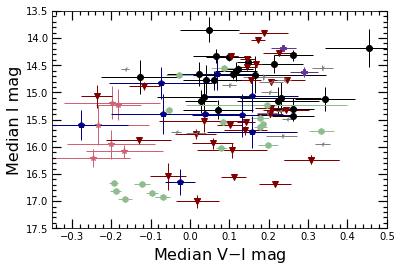

In [100]:
typeplot(x='median V-I',y='median I',yerr='stdev I',xerr='stdev V-I')
plt.xlim(-.35,.5)
plt.ylim(17.5,13.5)
plt.ylabel('Median I mag',fontsize=16)
plt.xlabel('Median V$-$I mag',fontsize=16)
plt.savefig('ColorFigsMar23/full_colormag.pdf',bbox_inches='tight')

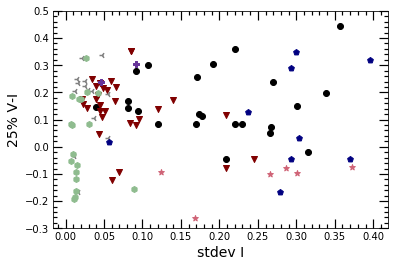

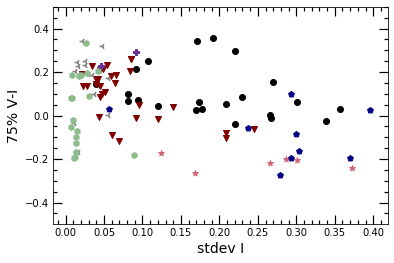

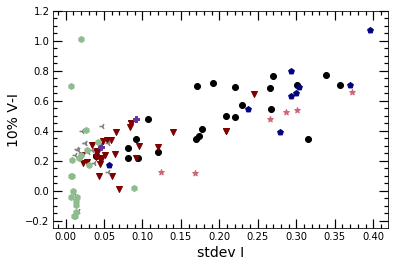

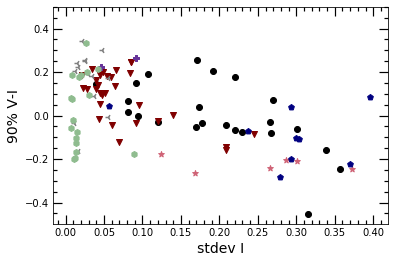

In [123]:
#notice clumping of type 5 but not type 6, of type 1 and similar for type 4
typeplot(x='stdev I',y='25% V-I')
plt.ylim(-.3,.5)
plt.show()
typeplot(x='stdev I',y='75% V-I')
plt.ylim(-.5,.5)
plt.show()

#and then more of a correlation at 90 and 10, likely because more color effect when high variability
typeplot(x='stdev I',y='10% V-I')
plt.ylim(-.25,1.2)
plt.show()

typeplot(x='stdev I',y='90% V-I')
plt.ylim(-.5,.5)
plt.show()

color at bright end - color at faint end vs. overall variabilility
so color changes more for more variable sources
this effect is as expected but do we expect this tight of a relation?


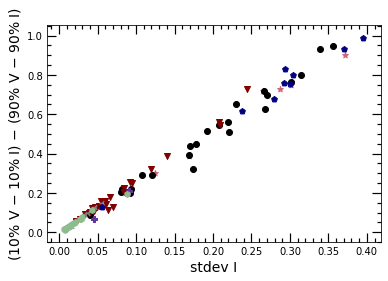

In [221]:
typeplot(x='stdev I',y='10% V-I',yminus='90% V-I')
plt.ylabel('(10% V $-$ 10% I) $-$ (90% V $-$ 90% I)')
print('color at bright end - color at faint end vs. overall variabilility')
print('so color changes more for more variable sources')
print('this effect is as expected but do we expect this tight of a relation?')

#for log x-axis:
# plt.xscale('log')
# plt.xlim(5e-3,0.5)
plt.savefig('color_difference_stdevI.pdf',bbox_inches='tight')

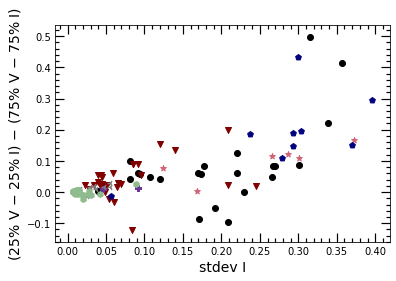

Text(0, 0.5, '(10% V $-$ 10% I) $-$ (75% V $-$ 75% I)')

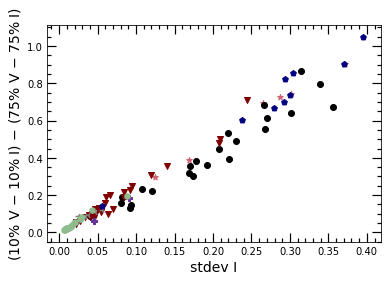

In [143]:
#notice relation tight above but not here
typeplot(x='stdev I',y='25% V-I',yminus='75% V-I')
plt.ylabel('(25% V $-$ 25% I) $-$ (75% V $-$ 75% I)')
plt.show()
#much closer to the above
typeplot(x='stdev I',y='10% V-I',yminus='75% V-I')
plt.ylabel('(10% V $-$ 10% I) $-$ (75% V $-$ 75% I)')

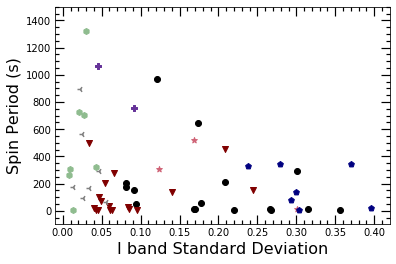

In [155]:
x = 'stdev I'
y = 'spin period'
for i in type1:
    row = summ[summ['src_n']==i].iloc[0] 
    if row['spin period']>0:plt.scatter(row[x],row[y],marker='*',label='1',color=pink)
for i in type2:
    row = summ[summ['src_n']==i].iloc[0]
    if row['spin period']>0:plt.scatter(row[x],row[y],color='black',label='2')
for i in type3:
    row = summ[summ['src_n']==i].iloc[0]
    if row['spin period']>0:plt.scatter(row[x],row[y],marker='v',label='3',color='maroon')
for i in type4:
    row = summ[summ['src_n']==i].iloc[0]
    if row['spin period']>0:plt.scatter(row[x],row[y],color='rebeccapurple',marker='P')        
for i in type5:
    row = summ[summ['src_n']==i].iloc[0]
    if row['spin period']>0:plt.scatter(row[x],row[y],marker='3',label='5',color='grey') 
for i in type6:
    row = summ[summ['src_n']==i].iloc[0]
    if row['spin period']>0:plt.scatter(row[x],row[y],color='darkseagreen',marker='h') 
for i in typet:
    row = summ[summ['src_n']==i].iloc[0]
    if row['spin period']>0:plt.scatter(row[x],row[y],marker='p',label='transition',color='navy')         
plt.ylim(-100,1500)
plt.xlim(-.01,.42)

plt.xlabel('I band Standard Deviation',fontsize=16)
plt.ylabel('Spin Period (s)',fontsize=16)
plt.savefig('spinperiod_stdevi.pdf',bbox_inches='tight')

(-3, 6)

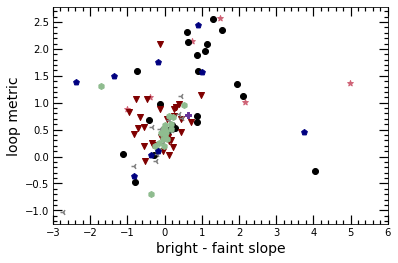

In [160]:
typeplot(x='bright - faint slope',y='loop metric')
plt.xlim(-3,6)

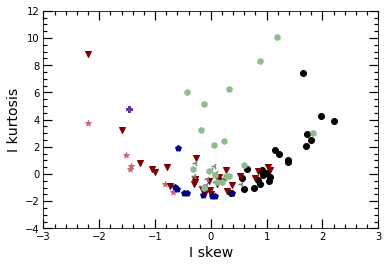

In [220]:
typeplot(x='I skew',y='I kurtosis')
plt.ylim(-6,40)
plt.ylim(-4,12)
plt.xlim(-3,3)
plt.savefig('overall_kurtosis_skew.pdf',bbox_inches='tight')

# color near base of type 1 and type 2 in comparison to ~quiescence

In [216]:
def basecolor(mag=0.05):
    '''plot color-mag near base for types 1 and 2
    mag: magnitude within max/min to use as base
    can simplify using marker, color choices based on types rather than separate loops
    '''
    for t in type1:
        try:iband,vband = o.getIV(t,cross,stack=True)
        except:iband,vband = o.getIV(t,cross2,mlist=mlist2,stack=True) 
        #get interp
        interp = np.interp(vband['MJD-50000'],iband['MJD-50000'],iband['I mag'])
        vi = vband['V mag'] - interp
        #get faintest 0.05 mags
        vband['V-I'] = vi; vband['I'] = interp
        maxi = np.max(interp)
        faint = vband[vband['I']>maxi-mag]
        #now scatter I and V-I from faint
        plt.errorbar(np.nanmean(faint['V-I']),np.nanmean(faint['I']),yerr=np.nanstd(faint['I']),xerr=np.nanstd(faint['V-I']),elinewidth=1,color=pink,marker='*',ls='none')
    for t in type2:
        try:iband,vband = o.getIV(t,cross,stack=True)
        except:iband,vband = o.getIV(t,cross2,mlist=mlist2,stack=True) 
        #get interp
        interp = np.interp(vband['MJD-50000'],iband['MJD-50000'],iband['I mag'])
        vi = vband['V mag'] - interp
        #get faintest 0.05 mags
        vband['V-I'] = vi; vband['I'] = interp
        mini = np.min(interp)
        bright = vband[vband['I']<mini+mag]
        #now scatter I and V-I from faint
        plt.errorbar(np.nanmean(bright['V-I']),np.nanmean(bright['I']),yerr=np.nanstd(bright['I']),xerr=np.nanstd(bright['V-I']),elinewidth=1,color='black',marker='o',ls='none') 
    plt.ylabel('I mag',fontsize=16)
    plt.xlabel('V$-$I mag',fontsize=16)

empty file for OIII I


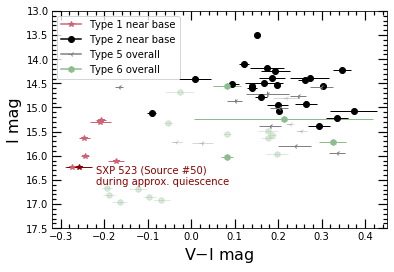

In [217]:
basecolor()
colors = ['grey','darkseagreen','darkred']
markers = ['3','h','*']
for t in type5+type6+[55]:
    if src_dict[t] not in exclude_all_from_color:
        if src_dict[t] in calibration_used: calib = True
        else: calib = False
        if t in type5:
            color = colors[0]
            marker = markers[0]
        elif t in type6:
            color = colors[1]
            marker = markers[1]
        else: 
            color = colors[2]
            marker = markers[2]
        if src_dict[t] in exclude_OII_from_color:iband,vband = exclude_OII(t,calib=calib)
        else:
            try:iband,vband = o.getIV(t,cross,stack=True,calib=calib)
            except:iband,vband = o.getIV(t,cross2,mlist=mlist2,stack=True,calib=calib) 
        interp = np.interp(vband['MJD-50000'],iband['MJD-50000'],iband['I mag'])
        vi = vband['V mag'] - interp
        vband['V-I'] = vi; vband['I'] = interp
        if t==55:vband = vband[vband['MJD-50000']<4700] #quiescent part
        if calib:plt.errorbar(np.nanmean(vband['V-I']),np.nanmean(vband['I']),yerr=np.nanstd(vband['I']),xerr=np.nanstd(vband['V-I']),alpha=0.3,elinewidth=1,color=color,marker=marker,ls='none')
        else: plt.errorbar(np.nanmean(vband['V-I']),np.nanmean(vband['I']),yerr=np.nanstd(vband['I']),xerr=np.nanstd(vband['V-I']),elinewidth=1,color=color,marker=marker,ls='none')
plt.xlim(-.32,.45)
plt.ylim(17.5,13)
plt.text(-0.22,16.35,'SXP 523 (Source #50)',color='darkred')
plt.text(-0.22,16.6,'during approx. quiescence',color='darkred')


legend_elements = [Line2D([0], [0], color=pink,marker='*', label='Type 1 near base'),
                   Line2D([0], [0], color='black',marker='o', label='Type 2 near base'),
                  Line2D([0], [0], color='grey',marker='3', label='Type 5 overall'),
                  Line2D([0], [0], color='darkseagreen',marker='h', label='Type 6 overall')]
plt.legend(handles=legend_elements)
plt.savefig('ColorFigsMar23/color_near_base.pdf',bbox_inches='tight')
